# Summarizing Research Outputs - Base dataset

In [79]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import time

# import the parquet library
import pyarrow.parquet as pq

# import model libraries
from sklearn.metrics import mean_squared_error, accuracy_score, mean_absolute_error

import statsmodels.api as sm
import statsmodels.formula.api as smf

In [80]:
# load the data base_portfolio_reg1.parquet and base_lvwreturns_reg1.parquet

# portfolios
# regressions
portfolio1 = pd.read_parquet('base_portfolio_reg1.parquet') # no RF
portfolio2 = pd.read_parquet('base_portfolio_reg2.parquet') # rf5
portfolio3 = pd.read_parquet('base_portfolio_reg3.parquet') # rf 10
portfolio4 = pd.read_parquet('base_portfolio_reg4.parquet') # rf expand
portfolio15 = pd.read_parquet('base_portfolio_reg5.parquet') # rf 20
portfolio16 = pd.read_parquet('base_portfolio_decileAC.parquet') # ridge evaluated on decile accuracy

# classification with accuracy
portfolio5 = pd.read_parquet('base_portfolio_class_ac1.parquet') # no RF
portfolio6 = pd.read_parquet('base_portfolio_class_ac2.parquet') # rf5
portfolio7 = pd.read_parquet('base_portfolio_class_ac3.parquet') # rf10
portfolio8 = pd.read_parquet('base_portfolio_class_ac4.parquet') # rf20
portfolio9 = pd.read_parquet('base_portfolio_class_ac5.parquet') # rf expand

# classification with mse
portfolio10 = pd.read_parquet('base_portfolio_class_mse1.parquet') # no RF
portfolio11 = pd.read_parquet('base_portfolio_class_mse2.parquet') # rf5
portfolio12 = pd.read_parquet('base_portfolio_class_mse3.parquet') # rf10
portfolio13 = pd.read_parquet('base_portfolio_class_mse4.parquet') # rf20
portfolio14 = pd.read_parquet('base_portfolio_class_mse5.parquet') # rf expand


## Prediction Evaluation (MAE, MSE, Accuracy) and Comparison of ML Algorithms

### Decile accuracy

In [81]:
# Assuming original portfolio DataFrames are named as such
dataframes = {
    'portfolio1': portfolio1,
    'portfolio2': portfolio2,
    'portfolio3': portfolio3, 
    'portfolio4': portfolio4,
    'portfolio5': portfolio5,
    'portfolio6': portfolio6,
    'portfolio7': portfolio7,
    'portfolio8': portfolio8,
    'portfolio9': portfolio9,
    'portfolio10': portfolio10,
    'portfolio11': portfolio11,
    'portfolio12': portfolio12,
    'portfolio13': portfolio13, 
    'portfolio14': portfolio14, 
    'portfolio15': portfolio15, 
    'portfolio16': portfolio16 
}

# Loop through the dictionary to drop columns
for name, df in dataframes.items():
    # Find columns that start with "position" or "decile"
    columns_to_drop = [col for col in df.columns if col.startswith('decile')]
    # Drop these columns
    df.drop(columns=columns_to_drop, inplace=True)
    # Update the dictionary with the modified DataFrame
    dataframes[name] = df

# Columns to be dropped
columns_to_drop = ['date', 'RET', 'ME']


# Loop through the dictionary, skipping the first item
for name, df in list(dataframes.items()):  # [1:] skips the first item
    # Check if DataFrame contains the columns to be dropped
    cols_to_drop = [col for col in columns_to_drop if col in df.columns]
    # Drop the columns if present
    if cols_to_drop:
        df.drop(columns=cols_to_drop, inplace=True)


# keep only predictions for the top and bottom deciles
for portfolio_name, df in dataframes.items():
    for col in df.columns:
        # If column does not start with "position_", check for a corresponding "position_" column
        if not col.startswith("position_"):
            position_col = f"position_{col}"
            if position_col in df.columns:
                # Replace model's value with NaN where position is 0
                df.loc[df[position_col] == 0, col] = np.nan
    # Drop columns starting with "position"
    df.drop(columns=[col for col in df.columns if col.startswith("position_")], inplace=True)
    
    # Update the dictionary with the modified dataframe
    dataframes[portfolio_name] = df



# Now, dataframes['portfolio1'], dataframes['portfolio2'], and dataframes['portfolio3'] have the columns dropped
# If you need to work directly with the modified portfolio1, portfolio2, and portfolio3, you can extract them like so:
portfolio1, portfolio2, portfolio3, portfolio4, portfolio5, portfolio6, portfolio7, portfolio8, portfolio9, portfolio10, portfolio11, porfolio12, portfolio13, portfolio14, portfolio15, portfolio16  = dataframes.values()

In [82]:
metrics_decile = pd.DataFrame(columns=['Accuracy', 'MAE', 'MSE'])

def calculate_accuracy(y_true, y_pred):
    # Exclude NaN values from both y_true and y_pred
    valid_indices = ~y_pred.isna()
    y_true_valid = y_true[valid_indices]
    y_pred_valid = y_pred[valid_indices]
    y_pred_class = (y_pred_valid >= 0.5).astype(int)
    accuracy = np.mean(y_true_valid == y_pred_class)
    return accuracy

# Loop over each portfolio DataFrame
for name, portfolio in dataframes.items():
    y = portfolio['y']
    for column in portfolio.columns:
        if column == 'y':
            continue  # Skip the 'y' column

        # Calculate metrics, excluding NaN values
        valid_indices = ~portfolio[column].isna()
        if valid_indices.sum() > 0:  # Proceed only if there are non-NaN predictions
            accuracy = calculate_accuracy(y[valid_indices], portfolio[column][valid_indices])
            mae = mean_absolute_error(y[valid_indices], portfolio[column][valid_indices])
            mse = mean_squared_error(y[valid_indices], portfolio[column][valid_indices])

            # Store metrics in the DataFrame
            metrics_decile.loc[column] = [accuracy, mae, mse]
        else:
            # Handle the case where all predictions are NaN
            metrics_decile.loc[column] = [np.nan, np.nan, np.nan]

# Display the DataFrame with the calculated metrics
metrics_decile.head()

,Accuracy,MAE,MSE
ols_default,0.977404,0.214626,0.087825
ridge_reg_exp,0.977609,0.214610,0.087752
DT_reg_exp,0.928003,0.088561,0.047383
ridge_reg_roll5,0.978340,0.217517,0.091180
DT_reg_roll5,0.897441,0.125503,0.067356


In [83]:

metrics_decile = metrics_decile.sort_values(by='Accuracy', ascending=False)
metrics_decile.head(10)

,Accuracy,MAE,MSE
RF_clas_exp_AC,0.990595,0.014757,0.006651
RF_class_roll5_AC,0.987301,0.036159,0.009794
RF_class_roll10_AC,0.986617,0.029510,0.009849
RF_class_roll20_MSE,0.986526,0.017113,0.009623
RF_class_roll5_MSE,0.986020,0.017753,0.010521
RF_class_roll20_AC,0.986006,0.026663,0.010061
RF_class_roll10_MSE,0.985444,0.019040,0.010728
ridge_clas_roll5_decAC,0.985377,0.017395,0.009546
ridge_clas_roll10_AC,0.985191,0.016907,0.009758
ridge_clas_roll20_AC,0.984796,0.017343,0.010019


In [84]:
metrics_decile.tail(10)

,Accuracy,MAE,MSE
DT_class_roll20_MSE,0.919314,0.096399,0.051606
DT_reg_roll20,0.919224,0.096475,0.051675
DT_clas_exp_AC,0.918183,0.101125,0.055254
DT_reg_roll10,0.908514,0.111155,0.058804
DT_class_roll10_MSE,0.908285,0.111269,0.058897
DT_class_roll20_AC,0.907864,0.112597,0.059926
DT_reg_roll5,0.897441,0.125503,0.067356
DT_class_roll5_MSE,0.893196,0.131147,0.069761
DT_class_roll10_AC,0.879704,0.150738,0.079125
DT_class_roll5_AC,0.869700,0.158696,0.084768


In [85]:


# display only rows where index = 'ridge_reg_roll5','ridge_clas_roll5_AC', 'ridge_clas_roll5_decAC', 'RF_class_roll5_AC', 'RF_reg_exp', 'ols_default'
print_metrics = ['ridge_reg_roll5','ridge_clas_roll5_AC', 'ridge_clas_roll5_decAC', 'RF_class_roll5_AC', 'RF_reg_exp', 'ols_default']
metrics_decile.loc[print_metrics].sort_values(by='Accuracy', ascending=False).head(10)


,Accuracy,MAE,MSE
RF_class_roll5_AC,0.987301,0.036159,0.009794
ridge_clas_roll5_decAC,0.985377,0.017395,0.009546
ridge_clas_roll5_AC,0.984683,0.017187,0.009949
ridge_reg_roll5,0.978340,0.217517,0.091180
ols_default,0.977404,0.214626,0.087825
RF_reg_exp,0.947332,0.066096,0.035387


In [86]:
# Iterate over the row labels (index) of the metrics_decile DataFrame
for label in metrics_decile.index:
    # Determine 'type'
    if "reg" in label:
        metrics_decile.loc[label, 'type'] = 'reg'
    elif "clas" in label:
        metrics_decile.loc[label, 'type'] = 'class'
    elif "ols" in label:
        metrics_decile.loc[label, 'type'] = 'reg'
    else:
        metrics_decile.loc[label, 'type'] = 'class'
    
    # Determine 'method'
    if "exp" in label:
        metrics_decile.loc[label, 'method'] = 'exp'
    elif "roll5" in label:
        metrics_decile.loc[label, 'method'] = 'roll5'
    elif "roll10" in label:
        metrics_decile.loc[label, 'method'] = 'roll10'
    elif "roll20" in label:
        metrics_decile.loc[label, 'method'] = 'roll20'
    else:
        metrics_decile.loc[label, 'method'] = 'exp'  
    
    # Determine 'metric'
    if label.endswith("AC"):
        metrics_decile.loc[label, 'metric'] = 'acc'
    else:
        metrics_decile.loc[label, 'metric'] = 'mse'

    # Determine 'Algorithm'
    if "ridge" in label:
        metrics_decile.loc[label, 'algorithm'] = 'ridge'
    elif "DT" in label:
        metrics_decile.loc[label, 'algorithm'] = 'DT'
    elif "RF" in label:
        metrics_decile.loc[label, 'algorithm'] = 'RF'
    else:
        metrics_decile.loc[label, 'algorithm'] = 'other'

# Now, metrics_decile contains the additional categorizations based on the index names.
metrics_decile.head(50)

,Accuracy,MAE,MSE,type,method,metric,algorithm
RF_clas_exp_AC,0.990595,0.014757,0.006651,class,exp,acc,RF
RF_class_roll5_AC,0.987301,0.036159,0.009794,class,roll5,acc,RF
RF_class_roll10_AC,0.986617,0.029510,0.009849,class,roll10,acc,RF
RF_class_roll20_MSE,0.986526,0.017113,0.009623,class,roll20,mse,RF
RF_class_roll5_MSE,0.986020,0.017753,0.010521,class,roll5,mse,RF
RF_class_roll20_AC,0.986006,0.026663,0.010061,class,roll20,acc,RF
RF_class_roll10_MSE,0.985444,0.019040,0.010728,class,roll10,mse,RF
ridge_clas_roll5_decAC,0.985377,0.017395,0.009546,class,roll5,acc,ridge
ridge_clas_roll10_AC,0.985191,0.016907,0.009758,class,roll10,acc,ridge
ridge_clas_roll20_AC,0.984796,0.017343,0.010019,class,roll20,acc,ridge


In [87]:
# First, generate dummy variables for categorical predictors
X = pd.get_dummies(metrics_decile[['type', 'method', 'algorithm']], drop_first=True)
# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Model 1: Accuracy as the dependent variable
y_accuracy = metrics_decile['Accuracy']
model_accuracy = sm.OLS(y_accuracy, X).fit()

# Model 2: MSE as the dependent variable
y_mse = metrics_decile['MSE']
model_mse = sm.OLS(y_mse, X).fit()

# Print the summary tables of both regressions
print("OLS Regression Model Summary (Dependent Variable: Accuracy)")
print(model_accuracy.summary())
print("\nOLS Regression Model Summary (Dependent Variable: MSE)")
print(model_mse.summary())

OLS Regression Model Summary (Dependent Variable: Accuracy)
                            OLS Regression Results                            
Dep. Variable:               Accuracy   R-squared:                       0.855
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     26.01
Date:                Wed, 06 Mar 2024   Prob (F-statistic):           2.72e-11
Time:                        16:22:28   Log-Likelihood:                 111.31
No. Observations:                  39   AIC:                            -206.6
Df Residuals:                      31   BIC:                            -193.3
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------

In [88]:
# print average accuracy grouped by type and method
print(metrics_decile.groupby(['type', 'method'])['Accuracy'].mean())

type   method
class  exp       0.964787
       roll10    0.954827
       roll20    0.961304
       roll5     0.955757
reg    exp       0.957587
       roll10    0.941903
       roll20    0.943535
       roll5     0.946802
Name: Accuracy, dtype: float64


### Overall Accuracy

Drop useless columns from portfolio dataframes.

In [89]:
# load the data base_portfolio_reg1.parquet and base_lvwreturns_reg1.parquet

# portfolios
# regressions
portfolio1 = pd.read_parquet('base_portfolio_reg1.parquet') # no RF
portfolio2 = pd.read_parquet('base_portfolio_reg2.parquet') # rf5
portfolio3 = pd.read_parquet('base_portfolio_reg3.parquet') # rf 10
portfolio4 = pd.read_parquet('base_portfolio_reg4.parquet') # rf expand
portfolio15 = pd.read_parquet('base_portfolio_reg5.parquet') # rf 20
portfolio16 = pd.read_parquet('base_portfolio_decileAC.parquet') # ridge evaluated on decile accuracy

# classification with accuracy
portfolio5 = pd.read_parquet('base_portfolio_class_ac1.parquet') # no RF
portfolio6 = pd.read_parquet('base_portfolio_class_ac2.parquet') # rf5
portfolio7 = pd.read_parquet('base_portfolio_class_ac3.parquet') # rf10
portfolio8 = pd.read_parquet('base_portfolio_class_ac4.parquet') # rf20
portfolio9 = pd.read_parquet('base_portfolio_class_ac5.parquet') # rf expand

# classification with mse
portfolio10 = pd.read_parquet('base_portfolio_class_mse1.parquet') # no RF
portfolio11 = pd.read_parquet('base_portfolio_class_mse2.parquet') # rf5
portfolio12 = pd.read_parquet('base_portfolio_class_mse3.parquet') # rf10
portfolio13 = pd.read_parquet('base_portfolio_class_mse4.parquet') # rf20
portfolio14 = pd.read_parquet('base_portfolio_class_mse5.parquet') # rf expand

In [90]:
# Assuming your DataFrames are already defined as portfolio1, portfolio2, and portfolio3
# Create a dictionary mapping names to DataFrame objects
dataframes = {
    'portfolio1': portfolio1,
    'portfolio2': portfolio2,
    'portfolio3': portfolio3, 
    'portfolio4': portfolio4,
    'portfolio5': portfolio5,
    'portfolio6': portfolio6,
    'portfolio7': portfolio7,
    'portfolio8': portfolio8,
    'portfolio9': portfolio9,
    'portfolio10': portfolio10,
    'portfolio11': portfolio11,
    'portfolio12': portfolio12,
    'portfolio13': portfolio13, 
    'portfolio14': portfolio14, 
    'portfolio15': portfolio15, 
    'portfolio16': portfolio16 
}

# Loop through the dictionary to drop columns
for name, df in dataframes.items():
    # Find columns that start with "position" or "decile"
    columns_to_drop = [col for col in df.columns if col.startswith('position') or col.startswith('decile')]
    # Drop these columns
    df.drop(columns=columns_to_drop, inplace=True)
    # Update the dictionary with the modified DataFrame
    dataframes[name] = df

# Columns to be dropped
columns_to_drop = ['date', 'RET', 'ME']


# Loop through the dictionary, skipping the first item
for name, df in list(dataframes.items()):  # [1:] skips the first item
    # Check if DataFrame contains the columns to be dropped
    cols_to_drop = [col for col in columns_to_drop if col in df.columns]
    # Drop the columns if present
    if cols_to_drop:
        df.drop(columns=cols_to_drop, inplace=True)


# Now, dataframes['portfolio1'], dataframes['portfolio2'], and dataframes['portfolio3'] have the columns dropped
# If you need to work directly with the modified portfolio1, portfolio2, and portfolio3, you can extract them like so:
portfolio1, portfolio2, portfolio3, portfolio4, portfolio5, portfolio6, portfolio7, portfolio8, portfolio9, portfolio10, portfolio11, porfolio12, portfolio13, portfolio14, portfolio15 , portfolio16  = dataframes.values()


In [91]:
# Initialize a DataFrame to store the metrics
metrics_df = pd.DataFrame(columns=['Accuracy', 'MAE', 'MSE'])

# Function to calculate accuracy assuming binary classification with threshold 0.5
def calculate_accuracy(y_true, y_pred):
    y_pred_class = (y_pred >= 0.5).astype(int)
    accuracy = np.mean(y_true == y_pred_class)
    return accuracy

# Loop over each portfolio DataFrame
for name, portfolio in dataframes.items():
    for column in portfolio.columns:
        if column == 'y' or column in metrics_df.index:
            continue  # Skip the 'y' column and any column already processed

        # Calculate metrics
        accuracy = calculate_accuracy(portfolio['y'], portfolio[column])
        mae = mean_absolute_error(portfolio['y'], portfolio[column])
        mse = mean_squared_error(portfolio['y'], portfolio[column])

        # Store metrics in the DataFrame
        metrics_df.loc[column] = [accuracy, mae, mse]

# Display the DataFrame with the calculated metrics
metrics_df.head()


,Accuracy,MAE,MSE
ols_default,0.823020,0.352016,0.152656
ridge_reg_exp,0.823176,0.352029,0.152646
DT_reg_exp,0.832284,0.205657,0.105550
ridge_reg_roll5,0.822525,0.352350,0.153341
DT_reg_roll5,0.825681,0.210039,0.109864


In [92]:
metrics_df = metrics_df.sort_values(by='Accuracy', ascending=False)
metrics_df.head(50)

,Accuracy,MAE,MSE
RF_clas_exp_AC,0.835806,0.218798,0.104737
ridge_clas_roll5_decAC,0.835803,0.208363,0.102729
ridge_clas_roll10_MSE,0.834998,0.207775,0.104047
ridge_clas_roll20_MSE,0.834953,0.208345,0.104256
ridge_clas_roll10_AC,0.834708,0.209025,0.104216
ridge_clas_roll20_AC,0.834427,0.209065,0.104394
ridge_clas_exp_MSE,0.834392,0.208347,0.104306
logit_default,0.834334,0.207177,0.104523
RF_class_roll10_AC,0.834325,0.223753,0.105871
ridge_clas_exp_AC,0.834298,0.208722,0.104377


In [93]:
metrics_df.tail(10)

,Accuracy,MAE,MSE
RF_reg_roll5,0.827564,0.209305,0.108440
DT_class_roll5_AC,0.826204,0.211955,0.111351
DT_class_roll5_MSE,0.826153,0.210152,0.109632
DT_reg_roll5,0.825681,0.210039,0.109864
ridge_reg_roll10,0.823577,0.352028,0.152658
ridge_reg_exp,0.823176,0.352029,0.152646
ridge_reg_roll5_decAC,0.823052,0.350800,0.152277
ols_default,0.823020,0.352016,0.152656
ridge_reg_roll20,0.822878,0.352083,0.152689
ridge_reg_roll5,0.822525,0.352350,0.153341


In [94]:
metrics_df.loc[print_metrics].sort_values(by='Accuracy', ascending=False).head(10)

,Accuracy,MAE,MSE
ridge_clas_roll5_decAC,0.835803,0.208363,0.102729
RF_class_roll5_AC,0.832964,0.233671,0.107796
ridge_clas_roll5_AC,0.832911,0.209604,0.104508
RF_reg_exp,0.832367,0.205493,0.105435
ols_default,0.823020,0.352016,0.152656
ridge_reg_roll5,0.822525,0.352350,0.153341


In [95]:
# Iterate over the row labels (index) of the DataFrame
for label in metrics_df.index:
    # Determine 'algorithm'
    if "reg" in label:
        metrics_df.loc[label, 'type'] = 'reg'
    elif "clas" in label:
        metrics_df.loc[label, 'type'] = 'class'
    elif "ols" in label:
        metrics_df.loc[label, 'type'] = 'reg'
    else:
        metrics_df.loc[label, 'type'] = 'class'
    
    # Determine 'method'
    if "exp" in label:
        metrics_df.loc[label, 'method'] = 'exp'
    elif "roll5" in label:
        metrics_df.loc[label, 'method'] = 'roll5'
    elif "roll10" in label:
        metrics_df.loc[label, 'method'] = 'roll10'
    elif "roll20" in label:
        metrics_df.loc[label, 'method'] = 'roll20'
    else:
        metrics_df.loc[label, 'method'] = 'exp'
    
    # Determine 'metric'
    if label.endswith("AC"):
        metrics_df.loc[label, 'metric'] = 'acc'
    else:
        metrics_df.loc[label, 'metric'] = 'mse'

    # Determine 'Algorithm'
    if "ridge" in label:
        metrics_df.loc[label, 'algorithm'] = 'ridge'
    elif "DT" in label:
        metrics_df.loc[label, 'algorithm'] = 'DT'
    elif "RF" in label:
        metrics_df.loc[label, 'algorithm'] = 'RF'
    else:
        metrics_df.loc[label, 'algorithm'] = 'other'


In [96]:
# sort the dataframe by MSE

metrics_df.sort_values(by='MSE', ascending=True, inplace=True)

metrics_df.head(10)

,Accuracy,MAE,MSE,type,method,metric,algorithm
ridge_clas_roll5_decAC,0.835803,0.208363,0.102729,class,roll5,acc,ridge
ridge_clas_roll5_MSE,0.834220,0.208011,0.104030,class,roll5,mse,ridge
ridge_clas_roll10_MSE,0.834998,0.207775,0.104047,class,roll10,mse,ridge
ridge_clas_roll10_AC,0.834708,0.209025,0.104216,class,roll10,acc,ridge
ridge_clas_roll20_MSE,0.834953,0.208345,0.104256,class,roll20,mse,ridge
ridge_clas_exp_MSE,0.834392,0.208347,0.104306,class,exp,mse,ridge
ridge_clas_exp_AC,0.834298,0.208722,0.104377,class,exp,acc,ridge
ridge_clas_roll20_AC,0.834427,0.209065,0.104394,class,roll20,acc,ridge
ridge_clas_roll5_AC,0.832911,0.209604,0.104508,class,roll5,acc,ridge
logit_default,0.834334,0.207177,0.104523,class,exp,mse,other


In [97]:
# First, generate dummy variables for categorical predictors
X = pd.get_dummies(metrics_df[['type', 'method', 'algorithm']], drop_first=True)
# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Model 1: Accuracy as the dependent variable
y_accuracy = metrics_df['Accuracy']
model_tot_accuracy = sm.OLS(y_accuracy, X).fit()

# Model 2: MSE as the dependent variable
y_mse = metrics_df['MSE']
model_tot_mse = sm.OLS(y_mse, X).fit()

# Print the summary tables of both regressions
print("OLS Regression Model Summary (Dependent Variable: Accuracy)")
print(model_tot_accuracy.summary())


OLS Regression Model Summary (Dependent Variable: Accuracy)
                            OLS Regression Results                            
Dep. Variable:               Accuracy   R-squared:                       0.576
Model:                            OLS   Adj. R-squared:                  0.480
Method:                 Least Squares   F-statistic:                     6.013
Date:                Wed, 06 Mar 2024   Prob (F-statistic):           0.000176
Time:                        16:22:56   Log-Likelihood:                 175.31
No. Observations:                  39   AIC:                            -334.6
Df Residuals:                      31   BIC:                            -321.3
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------

In [98]:
print("\nOLS Regression Model Summary (Dependent Variable: MSE)")
print(model_tot_mse.summary())


OLS Regression Model Summary (Dependent Variable: MSE)
                            OLS Regression Results                            
Dep. Variable:                    MSE   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.436
Method:                 Least Squares   F-statistic:                     5.193
Date:                Wed, 06 Mar 2024   Prob (F-statistic):           0.000541
Time:                        16:22:56   Log-Likelihood:                 119.02
No. Observations:                  39   AIC:                            -222.0
Df Residuals:                      31   BIC:                            -208.7
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

## Portfolio Comparison in terms of returns

In [99]:
# returns
returns1 = pd.read_parquet('base_lvwreturns_reg1.parquet') # no RF
returns2 = pd.read_parquet('base_lvwreturns_reg2.parquet')  # rf5
returns3 = pd.read_parquet('base_lvwreturns_reg3.parquet') # rf 10
returns4 = pd.read_parquet('base_lvwreturns_reg4.parquet') # rf expand
returns15 = pd.read_parquet('base_lvwreturns_reg5.parquet') # rf 20
returns16 = pd.read_parquet('base_lvwreturns_decileAC.parquet') # ridge evaluated on decile accuracy

returns5 = pd.read_parquet('base_lvwreturns_class_ac1.parquet')
returns6 = pd.read_parquet('base_lvwreturns_class_ac2.parquet')
returns7 = pd.read_parquet('base_lvwreturns_class_ac3.parquet')
returns8 = pd.read_parquet('base_lvwreturns_class_ac4.parquet')
returns9 = pd.read_parquet('base_lvwreturns_class_ac5.parquet')

returns10 = pd.read_parquet('base_lvwreturns_class_mse1.parquet')
returns11 = pd.read_parquet('base_lvwreturns_class_mse2.parquet')
returns12 = pd.read_parquet('base_lvwreturns_class_mse3.parquet')
returns13 = pd.read_parquet('base_lvwreturns_class_mse4.parquet')
returns14 = pd.read_parquet('base_lvwreturns_class_mse5.parquet')

### Handling the files

In [100]:
# drop the Mkt column from returns except for returns1

n_files = 16

# for "returns{i]" drop the Mkt column
for i in range(2, n_files + 1):
    returns = globals()[f'returns{i}']
    returns = returns.drop('Mkt', axis=1)
    globals()[f'returns{i}'] = returns

In [101]:
from functools import reduce

# Assuming your DataFrames are already loaded as returns1, returns2, ..., returns11
dataframes = [returns1, returns2, returns3, returns4, returns5, returns6,
               returns7, returns8, returns9, returns10, returns11, returns12, 
               returns13, returns14, returns15, returns16]

# Use functools.reduce to merge all DataFrames on 'date'
log_ret = reduce(lambda left, right: pd.merge(left, right, on='date', how='inner'), dataframes)

# Check the first few rows of the merged DataFrame
log_ret.head()


,date,vwreturn_ols_default_x,vwreturn_ridge_reg_exp,vwreturn_DT_reg_exp,vwreturn_ridge_reg_roll5,vwreturn_DT_reg_roll5,vwreturn_ridge_reg_roll10,vwreturn_DT_reg_roll10,vwreturn_ridge_reg_roll20,vwreturn_DT_reg_roll20,Mkt,vwreturn_RF_reg_roll5,vwreturn_RF_reg_roll10,vwreturn_RF_reg_exp,vwreturn_logit_default,vwreturn_ols_default_y,vwreturn_ridge_clas_exp_AC,vwreturn_DT_clas_exp_AC,vwreturn_ridge_clas_roll5_AC,vwreturn_DT_class_roll5_AC,vwreturn_ridge_clas_roll10_AC,vwreturn_DT_class_roll10_AC,vwreturn_ridge_clas_roll20_AC,vwreturn_DT_class_roll20_AC,vwreturn_RF_class_roll5_AC,vwreturn_RF_class_roll20_AC,vwreturn_RF_class_roll10_AC,vwreturn_RF_clas_exp_AC_x,vwreturn_ols_default,vwreturn_ridge_clas_exp_MSE,vwreturn_DT_clas_exp_MSE,vwreturn_ridge_clas_roll5_MSE,vwreturn_DT_class_roll5_MSE,vwreturn_ridge_clas_roll10_MSE,vwreturn_DT_class_roll10_MSE,vwreturn_ridge_clas_roll20_MSE,vwreturn_DT_class_roll20_MSE,vwreturn_RF_class_roll5_MSE,vwreturn_RF_class_roll10_MSE,vwreturn_RF_class_roll20_MSE,vwreturn_RF_clas_exp_AC_y,vwreturn_RF_reg_roll20,vwreturn_ridge_reg_roll5_decAC,vwreturn_ridge_clas_roll5_decAC
0,1933-01-31,0.020103,0.020103,0.005204,0.020128,0.006198,0.020128,0.006092,0.020128,0.006092,0.012521,0.006413,0.006196,0.006374,0.021328,0.020103,0.021328,0.005280,0.021328,0.006198,0.021328,0.005133,0.021328,0.006092,0.005968,0.005691,0.005691,0.006057,0.020103,0.021328,0.005280,0.021328,0.006198,0.021328,0.005133,0.021328,0.005133,0.028402,0.005691,0.005691,0.006057,0.006413,0.020812,0.021651
1,1933-02-28,0.010949,0.010949,0.088505,0.010949,0.063273,0.010949,0.088556,0.010949,0.088556,-0.165700,0.063273,0.063273,0.063273,0.008945,0.010949,0.008961,0.088505,0.008945,0.063273,0.008961,0.090977,0.008961,0.088556,0.054310,0.063444,0.063444,0.063321,0.010949,0.008961,0.088505,0.008945,0.063273,0.008961,0.090977,0.008961,0.090977,0.042952,0.063444,0.063444,0.063321,0.063273,0.010896,0.008877
2,1933-03-31,0.027653,0.027653,0.026092,0.027646,0.025901,0.027653,0.022960,0.027653,0.022960,0.032758,0.025886,0.026278,0.026389,0.028067,0.027653,0.028067,0.026092,0.028067,0.025901,0.028067,0.022960,0.028067,0.022960,0.026197,0.026529,0.026529,0.039669,0.027653,0.028067,0.026092,0.028067,0.025901,0.028067,0.022960,0.028067,0.022960,0.039075,0.026529,0.026529,0.039669,0.025886,0.027667,0.028089
3,1933-04-30,0.072490,0.072490,-0.018214,0.072490,-0.007145,0.072490,-0.011640,0.072490,-0.011640,0.328944,-0.006005,-0.003218,-0.006342,0.049104,0.072490,0.049104,-0.010030,0.048844,-0.007145,0.049104,-0.018204,0.049104,-0.011640,-0.002833,-0.007582,-0.007582,-0.008542,0.072490,0.049104,-0.010030,0.048844,-0.007145,0.049104,-0.018204,0.049104,-0.018204,-0.002805,-0.007582,-0.007582,-0.008542,-0.006005,0.072519,0.048863
4,1933-05-31,0.023893,0.023923,-0.283051,0.023923,-0.283051,0.022042,-0.283051,0.022042,-0.283051,0.194497,-0.004917,-0.003780,-0.004031,0.019600,0.023893,0.019139,-0.283051,0.019745,-0.283051,0.019139,-0.283051,0.019139,-0.283051,-0.003916,-0.003901,-0.003901,-0.004543,0.023893,0.019139,-0.283051,0.019688,-0.283051,0.019139,-0.283051,0.019139,-0.283051,-0.003916,-0.003901,-0.003901,-0.004543,-0.004917,0.023936,0.020442


In [102]:
# Filter columns that do not end with "_x", "_y", or "_z"
filtered_columns = [col for col in log_ret.columns if not col.endswith(('_y', '_z'))]

# Select only the filtered columns from the DataFrame

log_ret = log_ret[filtered_columns]


In [103]:
# Rename columns in 'log_ret' DataFrame
log_ret.rename(columns={col: col.replace('vwreturn', 'l') for col in log_ret.columns}, inplace=True)

# Check the updated column names
print(log_ret.columns)

Index(['date', 'l_ols_default_x', 'l_ridge_reg_exp', 'l_DT_reg_exp',
       'l_ridge_reg_roll5', 'l_DT_reg_roll5', 'l_ridge_reg_roll10',
       'l_DT_reg_roll10', 'l_ridge_reg_roll20', 'l_DT_reg_roll20', 'Mkt',
       'l_RF_reg_roll5', 'l_RF_reg_roll10', 'l_RF_reg_exp', 'l_logit_default',
       'l_ridge_clas_exp_AC', 'l_DT_clas_exp_AC', 'l_ridge_clas_roll5_AC',
       'l_DT_class_roll5_AC', 'l_ridge_clas_roll10_AC', 'l_DT_class_roll10_AC',
       'l_ridge_clas_roll20_AC', 'l_DT_class_roll20_AC', 'l_RF_class_roll5_AC',
       'l_RF_class_roll20_AC', 'l_RF_class_roll10_AC', 'l_RF_clas_exp_AC_x',
       'l_ols_default', 'l_ridge_clas_exp_MSE', 'l_DT_clas_exp_MSE',
       'l_ridge_clas_roll5_MSE', 'l_DT_class_roll5_MSE',
       'l_ridge_clas_roll10_MSE', 'l_DT_class_roll10_MSE',
       'l_ridge_clas_roll20_MSE', 'l_DT_class_roll20_MSE',
       'l_RF_class_roll5_MSE', 'l_RF_class_roll10_MSE',
       'l_RF_class_roll20_MSE', 'l_RF_reg_roll20', 'l_ridge_reg_roll5_decAC',
       'l_ridge_clas

In [104]:
# rename 'Mkt' column to 'l_Mkt'
log_ret.rename(columns={'Mkt': 'l_Mkt'}, inplace=True)

In [105]:
# calculate cumulative sum of each column except for the date column and store in a new DataFrame cum_log_ret, keep the date column
log_ret.sort_values('date', inplace=True)
log_ret.set_index('date', inplace=True)

cum_log_ret = log_ret.cumsum()
cum_log_ret.head()

,l_ols_default_x,l_ridge_reg_exp,l_DT_reg_exp,l_ridge_reg_roll5,l_DT_reg_roll5,l_ridge_reg_roll10,l_DT_reg_roll10,l_ridge_reg_roll20,l_DT_reg_roll20,l_Mkt,l_RF_reg_roll5,l_RF_reg_roll10,l_RF_reg_exp,l_logit_default,l_ridge_clas_exp_AC,l_DT_clas_exp_AC,l_ridge_clas_roll5_AC,l_DT_class_roll5_AC,l_ridge_clas_roll10_AC,l_DT_class_roll10_AC,l_ridge_clas_roll20_AC,l_DT_class_roll20_AC,l_RF_class_roll5_AC,l_RF_class_roll20_AC,l_RF_class_roll10_AC,l_RF_clas_exp_AC_x,l_ols_default,l_ridge_clas_exp_MSE,l_DT_clas_exp_MSE,l_ridge_clas_roll5_MSE,l_DT_class_roll5_MSE,l_ridge_clas_roll10_MSE,l_DT_class_roll10_MSE,l_ridge_clas_roll20_MSE,l_DT_class_roll20_MSE,l_RF_class_roll5_MSE,l_RF_class_roll10_MSE,l_RF_class_roll20_MSE,l_RF_reg_roll20,l_ridge_reg_roll5_decAC,l_ridge_clas_roll5_decAC
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1933-01-31,0.020103,0.020103,0.005204,0.020128,0.006198,0.020128,0.006092,0.020128,0.006092,0.012521,0.006413,0.006196,0.006374,0.021328,0.021328,0.005280,0.021328,0.006198,0.021328,0.005133,0.021328,0.006092,0.005968,0.005691,0.005691,0.006057,0.020103,0.021328,0.005280,0.021328,0.006198,0.021328,0.005133,0.021328,0.005133,0.028402,0.005691,0.005691,0.006413,0.020812,0.021651
1933-02-28,0.031051,0.031051,0.093709,0.031077,0.069471,0.031077,0.094648,0.031077,0.094648,-0.153179,0.069686,0.069469,0.069647,0.030273,0.030289,0.093785,0.030273,0.069471,0.030289,0.096110,0.030289,0.094648,0.060277,0.069134,0.069134,0.069379,0.031051,0.030289,0.093785,0.030273,0.069471,0.030289,0.096110,0.030289,0.096110,0.071354,0.069134,0.069134,0.069686,0.031707,0.030528
1933-03-31,0.058704,0.058704,0.119800,0.058723,0.095372,0.058730,0.117608,0.058730,0.117608,-0.120422,0.095571,0.095746,0.096036,0.058340,0.058356,0.119876,0.058340,0.095372,0.058356,0.119070,0.058356,0.117608,0.086475,0.095663,0.095663,0.109048,0.058704,0.058356,0.119876,0.058340,0.095372,0.058356,0.119070,0.058356,0.119070,0.110430,0.095663,0.095663,0.095571,0.059374,0.058616
1933-04-30,0.131195,0.131195,0.101586,0.131213,0.088227,0.131220,0.105968,0.131220,0.105968,0.208522,0.089567,0.092528,0.089694,0.107445,0.107460,0.109847,0.107184,0.088227,0.107460,0.100867,0.107460,0.105968,0.083641,0.088082,0.088082,0.100506,0.131195,0.107460,0.109847,0.107184,0.088227,0.107460,0.100867,0.107460,0.100867,0.107624,0.088082,0.088082,0.089567,0.131893,0.107479
1933-05-31,0.155088,0.155117,-0.181464,0.155136,-0.194824,0.153262,-0.177083,0.153262,-0.177083,0.403019,0.084650,0.088748,0.085663,0.127044,0.126599,-0.173204,0.126930,-0.194824,0.126599,-0.182184,0.126599,-0.177083,0.079725,0.084180,0.084180,0.095963,0.155088,0.126599,-0.173204,0.126872,-0.194824,0.126599,-0.182184,0.126599,-0.182184,0.103708,0.084180,0.084180,0.084650,0.155829,0.127922


### What methods perform the best

In [106]:
# calculate cumulative sum of each column except for the date column and store in a new DataFrame and keep only the last row
final_log_ret = cum_log_ret.iloc[-1]
final_log_ret.head() 

l_ols_default_x      16.606852
l_ridge_reg_exp      16.607910
l_DT_reg_exp         13.487748
l_ridge_reg_roll5    16.610957
l_DT_reg_roll5       12.115604
Name: 2022-07-31 00:00:00, dtype: float64

In [107]:
final_log_ret.tail() 

l_RF_class_roll10_MSE       11.078737
l_RF_class_roll20_MSE       10.794475
l_RF_reg_roll20             13.583264
l_ridge_reg_roll5_decAC     16.034024
l_ridge_clas_roll5_decAC    13.978240
Name: 2022-07-31 00:00:00, dtype: float64

In [108]:
# Convert final_log_ret Series to DataFrame and reset index
final_log_ret_df = final_log_ret.reset_index()

# Rename the columns
final_log_ret_df.columns = ['model', 'total_cum_logret']

# Check the first few rows of the updated DataFrame
print(final_log_ret_df.head())


               model  total_cum_logret
0    l_ols_default_x         16.606852
1    l_ridge_reg_exp         16.607910
2       l_DT_reg_exp         13.487748
3  l_ridge_reg_roll5         16.610957
4     l_DT_reg_roll5         12.115604


In [109]:
# Add 'Type' column
final_log_ret_df['Type'] = final_log_ret_df['model'].apply(
    lambda x: 'reg' if 'reg' in x else ('class' if 'clas' in x else 'other')
)

# Add 'Method' column
final_log_ret_df['Method'] = final_log_ret_df['model'].apply(
    lambda x: 'exp' if 'exp' in x else (
        'roll5' if 'roll5' in x else (
            'roll10' if 'roll10' in x else (
                'roll20' if 'roll20' in x else 'exp'
            )
        )
    )
)

# Add 'Metric' column
final_log_ret_df['Metric'] = final_log_ret_df['model'].apply(
    lambda x: 'acc' if x.endswith('AC') else 'mse'
)

# Add 'Algorithm' column
final_log_ret_df['Algorithm'] = final_log_ret_df['model'].apply(
    lambda x: 'ridge' if 'ridge' in x else (
        'DT' if 'DT' in x else (
            'RF' if 'RF' in x else 'other'
        )
    )
)

# Check the first few rows to verify the new columns
final_log_ret_df.head()


,model,total_cum_logret,Type,Method,Metric,Algorithm
0,l_ols_default_x,16.606852,other,exp,mse,other
1,l_ridge_reg_exp,16.607910,reg,exp,mse,ridge
2,l_DT_reg_exp,13.487748,reg,exp,mse,DT
3,l_ridge_reg_roll5,16.610957,reg,roll5,mse,ridge
4,l_DT_reg_roll5,12.115604,reg,roll5,mse,DT


In [110]:
# change the value of "Algoithm" column to reg if value in model column contains "ols"
final_log_ret_df.loc[final_log_ret_df['model'].str.contains('ols'), 'Algorithm'] = 'ols'
final_log_ret_df.loc[final_log_ret_df['model'].str.contains('ols'), 'Type'] = 'reg'

# change the value of "Algoithm" column to class if value in model column contains "logit"
final_log_ret_df.loc[final_log_ret_df['model'].str.contains('logit'), 'Type'] = 'class'
final_log_ret_df.loc[final_log_ret_df['model'].str.contains('logit'), 'Algorithm'] = 'logit'

In [111]:
# sort the final_log_ret_df DataFrame by 'total_cum_logret' in descending order

final_log_ret_df.sort_values('total_cum_logret', ascending=False, inplace=True)

final_log_ret_df.head(5)

,model,total_cum_logret,Type,Method,Metric,Algorithm
7,l_ridge_reg_roll20,16.621732,reg,roll20,mse,ridge
3,l_ridge_reg_roll5,16.610957,reg,roll5,mse,ridge
5,l_ridge_reg_roll10,16.610103,reg,roll10,mse,ridge
1,l_ridge_reg_exp,16.607910,reg,exp,mse,ridge
0,l_ols_default_x,16.606852,reg,exp,mse,ols


In [112]:
# print the 5 best performing models as a list

best_models = final_log_ret_df['model'].head(5).tolist()
print(best_models)

['l_ridge_reg_roll20', 'l_ridge_reg_roll5', 'l_ridge_reg_roll10', 'l_ridge_reg_exp', 'l_ols_default_x']


In [113]:
final_log_ret_df.tail(2)

,model,total_cum_logret,Type,Method,Metric,Algorithm
37,l_RF_class_roll20_MSE,10.794475,class,roll20,mse,RF
9,l_Mkt,9.689767,other,exp,mse,other


In [114]:
best_models

['l_ridge_reg_roll20',
 'l_ridge_reg_roll5',
 'l_ridge_reg_roll10',
 'l_ridge_reg_exp',
 'l_ols_default_x']

### Load Daniel-Moskowitz, FF momentum portfolios

In [115]:
log_ret.head()

,l_ols_default_x,l_ridge_reg_exp,l_DT_reg_exp,l_ridge_reg_roll5,l_DT_reg_roll5,l_ridge_reg_roll10,l_DT_reg_roll10,l_ridge_reg_roll20,l_DT_reg_roll20,l_Mkt,l_RF_reg_roll5,l_RF_reg_roll10,l_RF_reg_exp,l_logit_default,l_ridge_clas_exp_AC,l_DT_clas_exp_AC,l_ridge_clas_roll5_AC,l_DT_class_roll5_AC,l_ridge_clas_roll10_AC,l_DT_class_roll10_AC,l_ridge_clas_roll20_AC,l_DT_class_roll20_AC,l_RF_class_roll5_AC,l_RF_class_roll20_AC,l_RF_class_roll10_AC,l_RF_clas_exp_AC_x,l_ols_default,l_ridge_clas_exp_MSE,l_DT_clas_exp_MSE,l_ridge_clas_roll5_MSE,l_DT_class_roll5_MSE,l_ridge_clas_roll10_MSE,l_DT_class_roll10_MSE,l_ridge_clas_roll20_MSE,l_DT_class_roll20_MSE,l_RF_class_roll5_MSE,l_RF_class_roll10_MSE,l_RF_class_roll20_MSE,l_RF_reg_roll20,l_ridge_reg_roll5_decAC,l_ridge_clas_roll5_decAC
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1933-01-31,0.020103,0.020103,0.005204,0.020128,0.006198,0.020128,0.006092,0.020128,0.006092,0.012521,0.006413,0.006196,0.006374,0.021328,0.021328,0.005280,0.021328,0.006198,0.021328,0.005133,0.021328,0.006092,0.005968,0.005691,0.005691,0.006057,0.020103,0.021328,0.005280,0.021328,0.006198,0.021328,0.005133,0.021328,0.005133,0.028402,0.005691,0.005691,0.006413,0.020812,0.021651
1933-02-28,0.010949,0.010949,0.088505,0.010949,0.063273,0.010949,0.088556,0.010949,0.088556,-0.165700,0.063273,0.063273,0.063273,0.008945,0.008961,0.088505,0.008945,0.063273,0.008961,0.090977,0.008961,0.088556,0.054310,0.063444,0.063444,0.063321,0.010949,0.008961,0.088505,0.008945,0.063273,0.008961,0.090977,0.008961,0.090977,0.042952,0.063444,0.063444,0.063273,0.010896,0.008877
1933-03-31,0.027653,0.027653,0.026092,0.027646,0.025901,0.027653,0.022960,0.027653,0.022960,0.032758,0.025886,0.026278,0.026389,0.028067,0.028067,0.026092,0.028067,0.025901,0.028067,0.022960,0.028067,0.022960,0.026197,0.026529,0.026529,0.039669,0.027653,0.028067,0.026092,0.028067,0.025901,0.028067,0.022960,0.028067,0.022960,0.039075,0.026529,0.026529,0.025886,0.027667,0.028089
1933-04-30,0.072490,0.072490,-0.018214,0.072490,-0.007145,0.072490,-0.011640,0.072490,-0.011640,0.328944,-0.006005,-0.003218,-0.006342,0.049104,0.049104,-0.010030,0.048844,-0.007145,0.049104,-0.018204,0.049104,-0.011640,-0.002833,-0.007582,-0.007582,-0.008542,0.072490,0.049104,-0.010030,0.048844,-0.007145,0.049104,-0.018204,0.049104,-0.018204,-0.002805,-0.007582,-0.007582,-0.006005,0.072519,0.048863
1933-05-31,0.023893,0.023923,-0.283051,0.023923,-0.283051,0.022042,-0.283051,0.022042,-0.283051,0.194497,-0.004917,-0.003780,-0.004031,0.019600,0.019139,-0.283051,0.019745,-0.283051,0.019139,-0.283051,0.019139,-0.283051,-0.003916,-0.003901,-0.003901,-0.004543,0.023893,0.019139,-0.283051,0.019688,-0.283051,0.019139,-0.283051,0.019139,-0.283051,-0.003916,-0.003901,-0.003901,-0.004917,0.023936,0.020442


In [116]:
start_date = log_ret.index.min()
end_date = log_ret.index.max()

# load and clean DM returns (192701-201612)
DM_data = pd.read_fwf('moskowitz.txt', header=None)
DM_data.columns = 'date','mom_group','web_ret','ave_me','num_firm'
DM_data['date'] = pd.to_datetime(DM_data['date'].astype('str'), format='%Y-%m-%d', errors='ignore') + pd.offsets.MonthEnd(0)
DM_data = DM_data[['date','mom_group','web_ret']]
DM_data_pivot = DM_data.pivot(index='date', columns='mom_group', values='web_ret')
DM_data_pivot = DM_data_pivot.loc[start_date:end_date]
DM_data_mom = DM_data_pivot[10]-DM_data_pivot[1]

# DM_data_mom are returns of the momentum strategy - to be used for Sharpe and alphas


# cumulative returns for visualization
DM_data_mom_cum = DM_data_mom.copy()
DM_data_mom_cum = DM_data_mom.rename('Daniel-Moskowitz')
DM_data_mom_cum = np.log(DM_data_mom_cum + 1).cumsum()


In [117]:
# load FF_momentum.csv - data starts at row 12 and ends at row 1175

FF_mom = pd.read_csv('FF_momentum.csv', skiprows=10, nrows=1164, index_col=0)

# set the index to datetime
FF_mom.index = pd.to_datetime(FF_mom.index, format='%Y%m')

# set the index to the last day of the month
FF_mom.index = FF_mom.index + pd.offsets.MonthEnd(0)

# new column FF_mom = 'Hi PRIOR' - 'Lo PRIOR'
FF_mom['FF_mom'] = FF_mom['Hi PRIOR'] - FF_mom['Lo PRIOR']

# keep only the FF_mom column
FF_mom = FF_mom['FF_mom']/100

# keep only data from start_date to end_date
FF_mom = FF_mom.loc[start_date:end_date]

# FF_mom are returns of the momentum strategy - to be used for Sharpe and alphas

# transform the returns in FF_mom to logaritmic returns
FF_mom_cum = (1+FF_mom).cumprod()
FF_mom_cum = np.log(FF_mom_cum)
FF_mom_cum = FF_mom_cum.rename('Fama-French')
FF_mom_cum.tail()


2022-03-31    8.499917
2022-04-30    8.573632
2022-05-31    8.666666
2022-06-30    8.675230
2022-07-31    8.601152
Name: Fama-French, dtype: float64

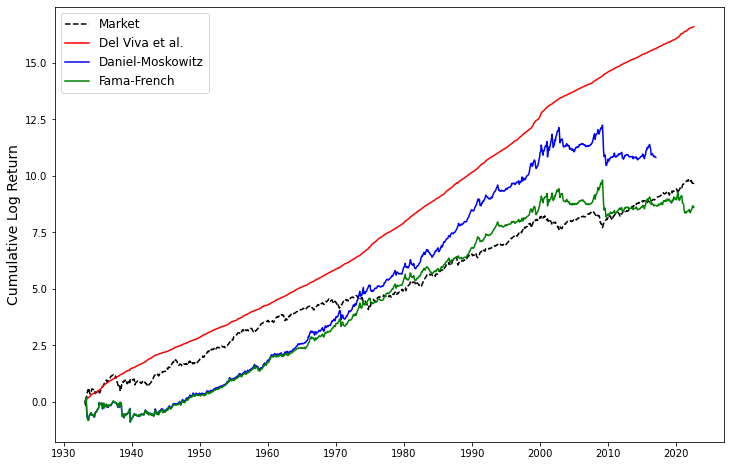

In [118]:
# Plot cumulative log returns for best_models


from matplotlib import lines


plt.figure(figsize=(12, 8))
#for model in best_models:
#    plt.plot(cum_log_ret.index, cum_log_ret[model], label=model)

#plot the 'l_Mkt' from cum_log_ret
plt.plot(cum_log_ret.index, cum_log_ret['l_Mkt'], label='Market', color='black', linestyle='dashed')

# plot 'l_ols_default' from cum_log_ret
plt.plot(cum_log_ret.index, cum_log_ret['l_ols_default'], label='Del Viva et al.', color='red')

# Plot the Daniel-Moskowitz momentum portfolio
plt.plot(DM_data_mom_cum.index, DM_data_mom_cum, label='Daniel-Moskowitz', color='blue')

# Plot the Fama-French momentum portfolio
plt.plot(FF_mom_cum.index, FF_mom_cum, label='Fama-French', color='green')


plt.ylabel('Cumulative Log Return', fontsize=14)
plt.legend(fontsize=12)
plt.show()


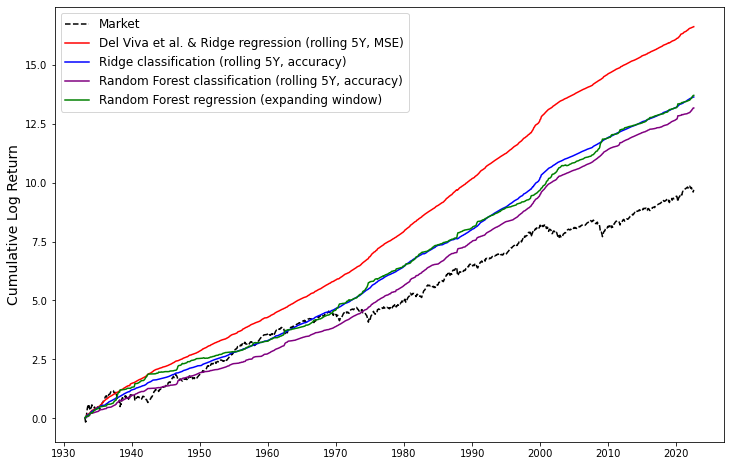

In [119]:

plt.figure(figsize=(12, 8))
#for model in best_models:
#    plt.plot(cum_log_ret.index, cum_log_ret[model], label=model)

#plot the 'l_Mkt' from cum_log_ret
plt.plot(cum_log_ret.index, cum_log_ret['l_Mkt'], label='Market', color='black', linestyle='dashed')

# plot 'l_ols_default' from cum_log_ret
plt.plot(cum_log_ret.index, cum_log_ret['l_ols_default'], label='Del Viva et al. & Ridge regression (rolling 5Y, MSE)', color='red')

# plot 'ridge_clas_roll5_AC' from cum_log_ret
plt.plot(cum_log_ret.index, cum_log_ret['l_ridge_clas_roll5_AC'], label='Ridge classification (rolling 5Y, accuracy)', color='blue')

# plot 'RF_class_roll5_AC' from cum_log_ret
plt.plot(cum_log_ret.index, cum_log_ret['l_RF_class_roll5_AC'], label='Random Forest classification (rolling 5Y, accuracy)', color='purple')

# plot 'RF_reg_exp' from cum_log_ret
plt.plot(cum_log_ret.index, cum_log_ret['l_RF_reg_exp'], label='Random Forest regression (expanding window)', color='green')

# plot l_DT_clas_exp_MSE
#plt.plot(cum_log_ret.index, cum_log_ret['l_DT_clas_exp_MSE'], label='Decision Tree classification (expanding window, MSE)', color='orange')

plt.ylabel('Cumulative Log Return', fontsize=14)
plt.legend(fontsize=12)
plt.show()#

### From log returns to normal returns

In [120]:
log_ret.head()

,l_ols_default_x,l_ridge_reg_exp,l_DT_reg_exp,l_ridge_reg_roll5,l_DT_reg_roll5,l_ridge_reg_roll10,l_DT_reg_roll10,l_ridge_reg_roll20,l_DT_reg_roll20,l_Mkt,l_RF_reg_roll5,l_RF_reg_roll10,l_RF_reg_exp,l_logit_default,l_ridge_clas_exp_AC,l_DT_clas_exp_AC,l_ridge_clas_roll5_AC,l_DT_class_roll5_AC,l_ridge_clas_roll10_AC,l_DT_class_roll10_AC,l_ridge_clas_roll20_AC,l_DT_class_roll20_AC,l_RF_class_roll5_AC,l_RF_class_roll20_AC,l_RF_class_roll10_AC,l_RF_clas_exp_AC_x,l_ols_default,l_ridge_clas_exp_MSE,l_DT_clas_exp_MSE,l_ridge_clas_roll5_MSE,l_DT_class_roll5_MSE,l_ridge_clas_roll10_MSE,l_DT_class_roll10_MSE,l_ridge_clas_roll20_MSE,l_DT_class_roll20_MSE,l_RF_class_roll5_MSE,l_RF_class_roll10_MSE,l_RF_class_roll20_MSE,l_RF_reg_roll20,l_ridge_reg_roll5_decAC,l_ridge_clas_roll5_decAC
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1933-01-31,0.020103,0.020103,0.005204,0.020128,0.006198,0.020128,0.006092,0.020128,0.006092,0.012521,0.006413,0.006196,0.006374,0.021328,0.021328,0.005280,0.021328,0.006198,0.021328,0.005133,0.021328,0.006092,0.005968,0.005691,0.005691,0.006057,0.020103,0.021328,0.005280,0.021328,0.006198,0.021328,0.005133,0.021328,0.005133,0.028402,0.005691,0.005691,0.006413,0.020812,0.021651
1933-02-28,0.010949,0.010949,0.088505,0.010949,0.063273,0.010949,0.088556,0.010949,0.088556,-0.165700,0.063273,0.063273,0.063273,0.008945,0.008961,0.088505,0.008945,0.063273,0.008961,0.090977,0.008961,0.088556,0.054310,0.063444,0.063444,0.063321,0.010949,0.008961,0.088505,0.008945,0.063273,0.008961,0.090977,0.008961,0.090977,0.042952,0.063444,0.063444,0.063273,0.010896,0.008877
1933-03-31,0.027653,0.027653,0.026092,0.027646,0.025901,0.027653,0.022960,0.027653,0.022960,0.032758,0.025886,0.026278,0.026389,0.028067,0.028067,0.026092,0.028067,0.025901,0.028067,0.022960,0.028067,0.022960,0.026197,0.026529,0.026529,0.039669,0.027653,0.028067,0.026092,0.028067,0.025901,0.028067,0.022960,0.028067,0.022960,0.039075,0.026529,0.026529,0.025886,0.027667,0.028089
1933-04-30,0.072490,0.072490,-0.018214,0.072490,-0.007145,0.072490,-0.011640,0.072490,-0.011640,0.328944,-0.006005,-0.003218,-0.006342,0.049104,0.049104,-0.010030,0.048844,-0.007145,0.049104,-0.018204,0.049104,-0.011640,-0.002833,-0.007582,-0.007582,-0.008542,0.072490,0.049104,-0.010030,0.048844,-0.007145,0.049104,-0.018204,0.049104,-0.018204,-0.002805,-0.007582,-0.007582,-0.006005,0.072519,0.048863
1933-05-31,0.023893,0.023923,-0.283051,0.023923,-0.283051,0.022042,-0.283051,0.022042,-0.283051,0.194497,-0.004917,-0.003780,-0.004031,0.019600,0.019139,-0.283051,0.019745,-0.283051,0.019139,-0.283051,0.019139,-0.283051,-0.003916,-0.003901,-0.003901,-0.004543,0.023893,0.019139,-0.283051,0.019688,-0.283051,0.019139,-0.283051,0.019139,-0.283051,-0.003916,-0.003901,-0.003901,-0.004917,0.023936,0.020442


In [121]:
# Copy the DataFrame to keep the date column unchanged
normal_ret = log_ret.copy()

# Apply the conversion to all columns except 'date'
for col in normal_ret.columns:
    if col != 'date':
        normal_ret[col] = np.exp(normal_ret[col]) - 1

# Display the head of the updated DataFrame to verify the changes
normal_ret.head()

,l_ols_default_x,l_ridge_reg_exp,l_DT_reg_exp,l_ridge_reg_roll5,l_DT_reg_roll5,l_ridge_reg_roll10,l_DT_reg_roll10,l_ridge_reg_roll20,l_DT_reg_roll20,l_Mkt,l_RF_reg_roll5,l_RF_reg_roll10,l_RF_reg_exp,l_logit_default,l_ridge_clas_exp_AC,l_DT_clas_exp_AC,l_ridge_clas_roll5_AC,l_DT_class_roll5_AC,l_ridge_clas_roll10_AC,l_DT_class_roll10_AC,l_ridge_clas_roll20_AC,l_DT_class_roll20_AC,l_RF_class_roll5_AC,l_RF_class_roll20_AC,l_RF_class_roll10_AC,l_RF_clas_exp_AC_x,l_ols_default,l_ridge_clas_exp_MSE,l_DT_clas_exp_MSE,l_ridge_clas_roll5_MSE,l_DT_class_roll5_MSE,l_ridge_clas_roll10_MSE,l_DT_class_roll10_MSE,l_ridge_clas_roll20_MSE,l_DT_class_roll20_MSE,l_RF_class_roll5_MSE,l_RF_class_roll10_MSE,l_RF_class_roll20_MSE,l_RF_reg_roll20,l_ridge_reg_roll5_decAC,l_ridge_clas_roll5_decAC
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1933-01-31,0.020306,0.020306,0.005217,0.020332,0.006217,0.020332,0.006111,0.020332,0.006111,0.0126,0.006433,0.006215,0.006394,0.021557,0.021557,0.005294,0.021557,0.006217,0.021557,0.005146,0.021557,0.006111,0.005985,0.005707,0.005707,0.006076,0.020306,0.021557,0.005294,0.021557,0.006217,0.021557,0.005146,0.021557,0.005146,0.028810,0.005707,0.005707,0.006433,0.021030,0.021887
1933-02-28,0.011009,0.011009,0.092540,0.011009,0.065318,0.011009,0.092595,0.011009,0.092595,-0.1527,0.065318,0.065318,0.065318,0.008985,0.009001,0.092540,0.008985,0.065318,0.009001,0.095244,0.009001,0.092595,0.055812,0.065499,0.065499,0.065369,0.011009,0.009001,0.092540,0.008985,0.065318,0.009001,0.095244,0.009001,0.095244,0.043888,0.065499,0.065499,0.065318,0.010955,0.008916
1933-03-31,0.028039,0.028039,0.026435,0.028032,0.026240,0.028039,0.023226,0.028039,0.023226,0.0333,0.026224,0.026626,0.026740,0.028465,0.028465,0.026435,0.028465,0.026240,0.028465,0.023226,0.028465,0.023226,0.026543,0.026884,0.026884,0.040466,0.028039,0.028465,0.026435,0.028465,0.026240,0.028465,0.023226,0.028465,0.023226,0.039849,0.026884,0.026884,0.026224,0.028053,0.028487
1933-04-30,0.075182,0.075182,-0.018050,0.075182,-0.007120,0.075182,-0.011573,0.075182,-0.011573,0.3895,-0.005987,-0.003213,-0.006322,0.050330,0.050330,-0.009979,0.050056,-0.007120,0.050330,-0.018039,0.050330,-0.011573,-0.002829,-0.007553,-0.007553,-0.008506,0.075182,0.050330,-0.009979,0.050056,-0.007120,0.050330,-0.018039,0.050330,-0.018039,-0.002801,-0.007553,-0.007553,-0.005987,0.075213,0.050076
1933-05-31,0.024181,0.024211,-0.246518,0.024211,-0.246518,0.022286,-0.246518,0.022286,-0.246518,0.2147,-0.004905,-0.003773,-0.004023,0.019793,0.019323,-0.246518,0.019942,-0.246518,0.019323,-0.246518,0.019323,-0.246518,-0.003908,-0.003893,-0.003893,-0.004533,0.024181,0.019323,-0.246518,0.019883,-0.246518,0.019323,-0.246518,0.019323,-0.246518,-0.003908,-0.003893,-0.003893,-0.004905,0.024225,0.020653


In [122]:
normal_ret.rename(columns={col: col.replace('l_', '') if col != 'date' else col for col in normal_ret.columns}, inplace=True)
normal_ret.head()

,ols_default_x,ridge_reg_exp,DT_reg_exp,ridge_reg_roll5,DT_reg_roll5,ridge_reg_roll10,DT_reg_roll10,ridge_reg_roll20,DT_reg_roll20,Mkt,RF_reg_roll5,RF_reg_roll10,RF_reg_exp,logit_default,ridge_clas_exp_AC,DT_clas_exp_AC,ridge_clas_roll5_AC,DT_class_roll5_AC,ridge_clas_roll10_AC,DT_class_roll10_AC,ridge_clas_roll20_AC,DT_class_roll20_AC,RF_class_roll5_AC,RF_class_roll20_AC,RF_class_roll10_AC,RF_clas_exp_AC_x,ols_default,ridge_clas_exp_MSE,DT_clas_exp_MSE,ridge_clas_roll5_MSE,DT_class_roll5_MSE,ridge_clas_roll10_MSE,DT_class_roll10_MSE,ridge_clas_roll20_MSE,DT_class_roll20_MSE,RF_class_roll5_MSE,RF_class_roll10_MSE,RF_class_roll20_MSE,RF_reg_roll20,ridge_reg_roll5_decAC,ridge_clas_roll5_decAC
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1933-01-31,0.020306,0.020306,0.005217,0.020332,0.006217,0.020332,0.006111,0.020332,0.006111,0.0126,0.006433,0.006215,0.006394,0.021557,0.021557,0.005294,0.021557,0.006217,0.021557,0.005146,0.021557,0.006111,0.005985,0.005707,0.005707,0.006076,0.020306,0.021557,0.005294,0.021557,0.006217,0.021557,0.005146,0.021557,0.005146,0.028810,0.005707,0.005707,0.006433,0.021030,0.021887
1933-02-28,0.011009,0.011009,0.092540,0.011009,0.065318,0.011009,0.092595,0.011009,0.092595,-0.1527,0.065318,0.065318,0.065318,0.008985,0.009001,0.092540,0.008985,0.065318,0.009001,0.095244,0.009001,0.092595,0.055812,0.065499,0.065499,0.065369,0.011009,0.009001,0.092540,0.008985,0.065318,0.009001,0.095244,0.009001,0.095244,0.043888,0.065499,0.065499,0.065318,0.010955,0.008916
1933-03-31,0.028039,0.028039,0.026435,0.028032,0.026240,0.028039,0.023226,0.028039,0.023226,0.0333,0.026224,0.026626,0.026740,0.028465,0.028465,0.026435,0.028465,0.026240,0.028465,0.023226,0.028465,0.023226,0.026543,0.026884,0.026884,0.040466,0.028039,0.028465,0.026435,0.028465,0.026240,0.028465,0.023226,0.028465,0.023226,0.039849,0.026884,0.026884,0.026224,0.028053,0.028487
1933-04-30,0.075182,0.075182,-0.018050,0.075182,-0.007120,0.075182,-0.011573,0.075182,-0.011573,0.3895,-0.005987,-0.003213,-0.006322,0.050330,0.050330,-0.009979,0.050056,-0.007120,0.050330,-0.018039,0.050330,-0.011573,-0.002829,-0.007553,-0.007553,-0.008506,0.075182,0.050330,-0.009979,0.050056,-0.007120,0.050330,-0.018039,0.050330,-0.018039,-0.002801,-0.007553,-0.007553,-0.005987,0.075213,0.050076
1933-05-31,0.024181,0.024211,-0.246518,0.024211,-0.246518,0.022286,-0.246518,0.022286,-0.246518,0.2147,-0.004905,-0.003773,-0.004023,0.019793,0.019323,-0.246518,0.019942,-0.246518,0.019323,-0.246518,0.019323,-0.246518,-0.003908,-0.003893,-0.003893,-0.004533,0.024181,0.019323,-0.246518,0.019883,-0.246518,0.019323,-0.246518,0.019323,-0.246518,-0.003908,-0.003893,-0.003893,-0.004905,0.024225,0.020653


## Bringing in the market data, factors

In [123]:
# load csv from "C:\Users\tomta\Tomas\School\03_Magistr\02_Business Analytics\10_BA_Thesis\03_Modeling\02_Sign prediction\FF3_clean.csv"
ff3 = pd.read_csv('C:\\Users\\tomta\\Tomas\\School\\03_Magistr\\02_Business Analytics\\10_BA_Thesis\\03_Modeling\\02_Sign prediction\\FF3_clean.csv')
ff5 = pd.read_csv('C:\\Users\\tomta\\Tomas\\School\\03_Magistr\\02_Business Analytics\\10_BA_Thesis\\03_Modeling\\02_Sign prediction\\FF5_clean.csv')

In [124]:
ff3.head()

,date,Mkt-RF,SMB,HML,RF
0,1926-07-31,2.96,-2.56,-2.43,0.22
1,1926-08-31,2.64,-1.17,3.82,0.25
2,1926-09-30,0.36,-1.40,0.13,0.23
3,1926-10-31,-3.24,-0.09,0.70,0.32
4,1926-11-30,2.53,-0.10,-0.51,0.31


In [125]:
ff3['date'] = pd.to_datetime(ff3['date'])
ff5['date'] = pd.to_datetime(ff5['date'])

# rename SMB and HML columns in ff3 to SMB3 and HML3
ff3.rename(columns={'SMB': 'SMB3', 'HML': 'HML3'}, inplace=True)

# rename SMB and HML columns in ff5 to SMB5 and HML5 and RMW and CMA to RMW5 and CMA5
ff5.rename(columns={'SMB': 'SMB5', 'HML': 'HML5', 'RMW': 'RMW5', 'CMA': 'CMA5'}, inplace=True)

# drop the Mkt-RF and RF column from ff5
ff5 = ff5.drop(['Mkt-RF', 'RF'], axis=1)

# divide all columns in ff3 by 100 (except for the date column)
ff3.iloc[:, 1:] = ff3.iloc[:, 1:] / 100


# merge the ff3 and ff5 DataFrames to one dataframe
factors = pd.merge(ff3, ff5, on='date', how='left')

factors.tail()

,date,Mkt-RF,SMB3,HML3,RF,SMB5,HML5,RMW5,CMA5
1165,2023-08-31,-0.0239,-0.0316,-0.0106,0.0045,-0.0365,-0.0106,0.0343,-0.0237
1166,2023-09-30,-0.0524,-0.0251,0.0152,0.0043,-0.0180,0.0152,0.0186,-0.0083
1167,2023-10-31,-0.0319,-0.0387,0.0019,0.0047,-0.0404,0.0019,0.0246,-0.0066
1168,2023-11-30,0.0884,-0.0002,0.0164,0.0044,-0.0012,0.0164,-0.0391,-0.0100
1169,2023-12-31,0.0485,0.0635,0.0494,0.0043,0.0732,0.0494,-0.0307,0.0132


In [126]:
models = normal_ret.columns
models.drop('Mkt')

Index(['ols_default_x', 'ridge_reg_exp', 'DT_reg_exp', 'ridge_reg_roll5',
       'DT_reg_roll5', 'ridge_reg_roll10', 'DT_reg_roll10', 'ridge_reg_roll20',
       'DT_reg_roll20', 'RF_reg_roll5', 'RF_reg_roll10', 'RF_reg_exp',
       'logit_default', 'ridge_clas_exp_AC', 'DT_clas_exp_AC',
       'ridge_clas_roll5_AC', 'DT_class_roll5_AC', 'ridge_clas_roll10_AC',
       'DT_class_roll10_AC', 'ridge_clas_roll20_AC', 'DT_class_roll20_AC',
       'RF_class_roll5_AC', 'RF_class_roll20_AC', 'RF_class_roll10_AC',
       'RF_clas_exp_AC_x', 'ols_default', 'ridge_clas_exp_MSE',
       'DT_clas_exp_MSE', 'ridge_clas_roll5_MSE', 'DT_class_roll5_MSE',
       'ridge_clas_roll10_MSE', 'DT_class_roll10_MSE', 'ridge_clas_roll20_MSE',
       'DT_class_roll20_MSE', 'RF_class_roll5_MSE', 'RF_class_roll10_MSE',
       'RF_class_roll20_MSE', 'RF_reg_roll20', 'ridge_reg_roll5_decAC',
       'ridge_clas_roll5_decAC'],
      dtype='object')

In [127]:
# merge ff3 to normal_ret on 'date'
normal_ret = normal_ret.merge(factors, on='date', how='inner')

normal_ret.head()

,date,ols_default_x,ridge_reg_exp,DT_reg_exp,ridge_reg_roll5,DT_reg_roll5,ridge_reg_roll10,DT_reg_roll10,ridge_reg_roll20,DT_reg_roll20,Mkt,RF_reg_roll5,RF_reg_roll10,RF_reg_exp,logit_default,ridge_clas_exp_AC,DT_clas_exp_AC,ridge_clas_roll5_AC,DT_class_roll5_AC,ridge_clas_roll10_AC,DT_class_roll10_AC,ridge_clas_roll20_AC,DT_class_roll20_AC,RF_class_roll5_AC,RF_class_roll20_AC,RF_class_roll10_AC,RF_clas_exp_AC_x,ols_default,ridge_clas_exp_MSE,DT_clas_exp_MSE,ridge_clas_roll5_MSE,DT_class_roll5_MSE,ridge_clas_roll10_MSE,DT_class_roll10_MSE,ridge_clas_roll20_MSE,DT_class_roll20_MSE,RF_class_roll5_MSE,RF_class_roll10_MSE,RF_class_roll20_MSE,RF_reg_roll20,ridge_reg_roll5_decAC,ridge_clas_roll5_decAC,Mkt-RF,SMB3,HML3,RF,SMB5,HML5,RMW5,CMA5
0,1933-01-31,0.020306,0.020306,0.005217,0.020332,0.006217,0.020332,0.006111,0.020332,0.006111,0.0126,0.006433,0.006215,0.006394,0.021557,0.021557,0.005294,0.021557,0.006217,0.021557,0.005146,0.021557,0.006111,0.005985,0.005707,0.005707,0.006076,0.020306,0.021557,0.005294,0.021557,0.006217,0.021557,0.005146,0.021557,0.005146,0.028810,0.005707,0.005707,0.006433,0.021030,0.021887,0.0125,0.0063,0.0636,0.0001,NaN,NaN,NaN,NaN
1,1933-02-28,0.011009,0.011009,0.092540,0.011009,0.065318,0.011009,0.092595,0.011009,0.092595,-0.1527,0.065318,0.065318,0.065318,0.008985,0.009001,0.092540,0.008985,0.065318,0.009001,0.095244,0.009001,0.092595,0.055812,0.065499,0.065499,0.065369,0.011009,0.009001,0.092540,0.008985,0.065318,0.009001,0.095244,0.009001,0.095244,0.043888,0.065499,0.065499,0.065318,0.010955,0.008916,-0.1524,-0.0258,-0.0295,-0.0003,NaN,NaN,NaN,NaN
2,1933-03-31,0.028039,0.028039,0.026435,0.028032,0.026240,0.028039,0.023226,0.028039,0.023226,0.0333,0.026224,0.026626,0.026740,0.028465,0.028465,0.026435,0.028465,0.026240,0.028465,0.023226,0.028465,0.023226,0.026543,0.026884,0.026884,0.040466,0.028039,0.028465,0.026435,0.028465,0.026240,0.028465,0.023226,0.028465,0.023226,0.039849,0.026884,0.026884,0.026224,0.028053,0.028487,0.0329,0.0379,0.0754,0.0004,NaN,NaN,NaN,NaN
3,1933-04-30,0.075182,0.075182,-0.018050,0.075182,-0.007120,0.075182,-0.011573,0.075182,-0.011573,0.3895,-0.005987,-0.003213,-0.006322,0.050330,0.050330,-0.009979,0.050056,-0.007120,0.050330,-0.018039,0.050330,-0.011573,-0.002829,-0.007553,-0.007553,-0.008506,0.075182,0.050330,-0.009979,0.050056,-0.007120,0.050330,-0.018039,0.050330,-0.018039,-0.002801,-0.007553,-0.007553,-0.005987,0.075213,0.050076,0.3885,0.0307,0.1965,0.0010,NaN,NaN,NaN,NaN
4,1933-05-31,0.024181,0.024211,-0.246518,0.024211,-0.246518,0.022286,-0.246518,0.022286,-0.246518,0.2147,-0.004905,-0.003773,-0.004023,0.019793,0.019323,-0.246518,0.019942,-0.246518,0.019323,-0.246518,0.019323,-0.246518,-0.003908,-0.003893,-0.003893,-0.004533,0.024181,0.019323,-0.246518,0.019883,-0.246518,0.019323,-0.246518,0.019323,-0.246518,-0.003908,-0.003893,-0.003893,-0.004905,0.024225,0.020653,0.2143,0.3656,0.1919,0.0004,NaN,NaN,NaN,NaN


In [128]:
normal_ret.tail()

,date,ols_default_x,ridge_reg_exp,DT_reg_exp,ridge_reg_roll5,DT_reg_roll5,ridge_reg_roll10,DT_reg_roll10,ridge_reg_roll20,DT_reg_roll20,Mkt,RF_reg_roll5,RF_reg_roll10,RF_reg_exp,logit_default,ridge_clas_exp_AC,DT_clas_exp_AC,ridge_clas_roll5_AC,DT_class_roll5_AC,ridge_clas_roll10_AC,DT_class_roll10_AC,ridge_clas_roll20_AC,DT_class_roll20_AC,RF_class_roll5_AC,RF_class_roll20_AC,RF_class_roll10_AC,RF_clas_exp_AC_x,ols_default,ridge_clas_exp_MSE,DT_clas_exp_MSE,ridge_clas_roll5_MSE,DT_class_roll5_MSE,ridge_clas_roll10_MSE,DT_class_roll10_MSE,ridge_clas_roll20_MSE,DT_class_roll20_MSE,RF_class_roll5_MSE,RF_class_roll10_MSE,RF_class_roll20_MSE,RF_reg_roll20,ridge_reg_roll5_decAC,ridge_clas_roll5_decAC,Mkt-RF,SMB3,HML3,RF,SMB5,HML5,RMW5,CMA5
1067,2022-03-31,0.014318,0.014318,0.009571,0.013887,-0.015431,0.013858,0.007564,0.013870,0.009637,0.0306,0.009420,0.008878,0.009380,0.014024,0.014030,0.009571,0.013869,0.008471,0.013871,0.007564,0.013876,0.007833,0.009936,0.013365,0.006730,0.017350,0.014318,0.014024,0.009571,0.013869,-0.015431,0.013871,0.007564,0.013869,0.009637,0.009800,0.004212,0.009549,0.009420,0.013718,0.013896,0.0305,-0.0161,-0.0181,0.0001,-0.0217,-0.0181,-0.0153,0.0314
1068,2022-04-30,0.009492,0.009492,0.066299,0.009537,0.068328,0.009529,0.066946,0.009501,0.066277,-0.0945,0.066495,0.064895,0.064568,0.008764,0.008764,0.066299,0.009240,0.067641,0.009169,0.066946,0.009168,0.068328,0.053011,0.012658,0.026459,0.013642,0.009492,0.008764,0.066299,0.009240,0.068328,0.009169,0.066946,0.009168,0.066277,0.039153,0.014455,0.026360,0.066495,0.010312,0.010704,-0.0946,-0.0139,0.0617,0.0001,-0.0039,0.0617,0.0352,0.0589
1069,2022-05-31,0.011138,0.011138,0.018353,0.011605,0.001453,0.011811,0.010898,0.011782,0.015816,-0.0031,0.023196,0.023012,0.019670,0.011026,0.011026,0.018353,0.011270,0.010905,0.011252,0.010898,0.011252,0.015445,0.022782,0.020322,0.022701,0.005700,0.011138,0.011026,0.018353,0.011270,0.001453,0.011252,0.010898,0.011252,0.015816,0.023250,0.017302,0.023139,0.023196,0.011049,0.010929,-0.0034,-0.0183,0.0839,0.0003,-0.0006,0.0839,0.0156,0.0397
1070,2022-06-30,0.006128,0.006128,0.042746,0.006481,0.045193,0.006135,0.045153,0.006135,0.043161,-0.0837,0.042822,0.043101,0.042652,0.006709,0.006709,0.042746,0.007113,0.042825,0.007107,0.045153,0.007113,0.045193,0.042837,0.018757,0.039566,0.006609,0.006128,0.006709,0.042746,0.007113,0.045193,0.007113,0.045153,0.007113,0.043161,0.042885,0.025767,0.039030,0.042822,0.006408,0.006949,-0.0843,0.0210,-0.0597,0.0006,0.0130,-0.0597,0.0181,-0.0469
1071,2022-07-31,0.011146,0.011146,0.003656,0.011017,-0.095742,0.010834,0.002420,0.011013,0.001788,0.0965,0.003564,0.003557,0.003675,0.008687,0.008687,0.003656,0.008704,0.002108,0.008704,0.002420,0.008706,-0.006259,0.003438,0.010134,0.003489,0.009401,0.011146,0.008687,0.003656,0.008704,-0.095742,0.008704,0.002420,0.008706,0.001788,0.003582,0.024070,0.003619,0.003564,0.011003,0.008847,0.0957,0.0281,-0.0405,0.0008,0.0182,-0.0405,0.0082,-0.0683


In [129]:
# merge the normal_ret DataFrame with the DM_data_mom and FF_mom 

DM_data_mom = DM_data_mom.to_frame()
FF_mom = FF_mom.to_frame()

# rename DM_data_mom column from 0 to DM_mom
DM_data_mom.rename(columns={0: 'DM_mom'}, inplace=True)
FF_mom.rename(columns={0: 'FF_mom'}, inplace=True)

FF_mom.head()



,FF_mom
1933-01-31,-0.0139
1933-02-28,0.0849
1933-03-31,0.1496
1933-04-30,-0.4409
1933-05-31,-0.2703


In [130]:
# in FF_mom, index has name 'date'

FF_mom.index.name = 'date'

FF_mom.head()

,FF_mom
date,
1933-01-31,-0.0139
1933-02-28,0.0849
1933-03-31,0.1496
1933-04-30,-0.4409
1933-05-31,-0.2703


In [131]:

DM_data_mom.head()  

,DM_mom
date,
1933-01-31,-0.01945
1933-02-28,0.09542
1933-03-31,0.12789
1933-04-30,-0.44002
1933-05-31,-0.27349


In [132]:
normal_ret = normal_ret.merge(DM_data_mom, on='date', how='left')
normal_ret = normal_ret.merge(FF_mom, on='date', how='left')

normal_ret.head()

,date,ols_default_x,ridge_reg_exp,DT_reg_exp,ridge_reg_roll5,DT_reg_roll5,ridge_reg_roll10,DT_reg_roll10,ridge_reg_roll20,DT_reg_roll20,Mkt,RF_reg_roll5,RF_reg_roll10,RF_reg_exp,logit_default,ridge_clas_exp_AC,DT_clas_exp_AC,ridge_clas_roll5_AC,DT_class_roll5_AC,ridge_clas_roll10_AC,DT_class_roll10_AC,ridge_clas_roll20_AC,DT_class_roll20_AC,RF_class_roll5_AC,RF_class_roll20_AC,RF_class_roll10_AC,RF_clas_exp_AC_x,ols_default,ridge_clas_exp_MSE,DT_clas_exp_MSE,ridge_clas_roll5_MSE,DT_class_roll5_MSE,ridge_clas_roll10_MSE,DT_class_roll10_MSE,ridge_clas_roll20_MSE,DT_class_roll20_MSE,RF_class_roll5_MSE,RF_class_roll10_MSE,RF_class_roll20_MSE,RF_reg_roll20,ridge_reg_roll5_decAC,ridge_clas_roll5_decAC,Mkt-RF,SMB3,HML3,RF,SMB5,HML5,RMW5,CMA5,DM_mom,FF_mom
0,1933-01-31,0.020306,0.020306,0.005217,0.020332,0.006217,0.020332,0.006111,0.020332,0.006111,0.0126,0.006433,0.006215,0.006394,0.021557,0.021557,0.005294,0.021557,0.006217,0.021557,0.005146,0.021557,0.006111,0.005985,0.005707,0.005707,0.006076,0.020306,0.021557,0.005294,0.021557,0.006217,0.021557,0.005146,0.021557,0.005146,0.028810,0.005707,0.005707,0.006433,0.021030,0.021887,0.0125,0.0063,0.0636,0.0001,NaN,NaN,NaN,NaN,-0.01945,-0.0139
1,1933-02-28,0.011009,0.011009,0.092540,0.011009,0.065318,0.011009,0.092595,0.011009,0.092595,-0.1527,0.065318,0.065318,0.065318,0.008985,0.009001,0.092540,0.008985,0.065318,0.009001,0.095244,0.009001,0.092595,0.055812,0.065499,0.065499,0.065369,0.011009,0.009001,0.092540,0.008985,0.065318,0.009001,0.095244,0.009001,0.095244,0.043888,0.065499,0.065499,0.065318,0.010955,0.008916,-0.1524,-0.0258,-0.0295,-0.0003,NaN,NaN,NaN,NaN,0.09542,0.0849
2,1933-03-31,0.028039,0.028039,0.026435,0.028032,0.026240,0.028039,0.023226,0.028039,0.023226,0.0333,0.026224,0.026626,0.026740,0.028465,0.028465,0.026435,0.028465,0.026240,0.028465,0.023226,0.028465,0.023226,0.026543,0.026884,0.026884,0.040466,0.028039,0.028465,0.026435,0.028465,0.026240,0.028465,0.023226,0.028465,0.023226,0.039849,0.026884,0.026884,0.026224,0.028053,0.028487,0.0329,0.0379,0.0754,0.0004,NaN,NaN,NaN,NaN,0.12789,0.1496
3,1933-04-30,0.075182,0.075182,-0.018050,0.075182,-0.007120,0.075182,-0.011573,0.075182,-0.011573,0.3895,-0.005987,-0.003213,-0.006322,0.050330,0.050330,-0.009979,0.050056,-0.007120,0.050330,-0.018039,0.050330,-0.011573,-0.002829,-0.007553,-0.007553,-0.008506,0.075182,0.050330,-0.009979,0.050056,-0.007120,0.050330,-0.018039,0.050330,-0.018039,-0.002801,-0.007553,-0.007553,-0.005987,0.075213,0.050076,0.3885,0.0307,0.1965,0.0010,NaN,NaN,NaN,NaN,-0.44002,-0.4409
4,1933-05-31,0.024181,0.024211,-0.246518,0.024211,-0.246518,0.022286,-0.246518,0.022286,-0.246518,0.2147,-0.004905,-0.003773,-0.004023,0.019793,0.019323,-0.246518,0.019942,-0.246518,0.019323,-0.246518,0.019323,-0.246518,-0.003908,-0.003893,-0.003893,-0.004533,0.024181,0.019323,-0.246518,0.019883,-0.246518,0.019323,-0.246518,0.019323,-0.246518,-0.003908,-0.003893,-0.003893,-0.004905,0.024225,0.020653,0.2143,0.3656,0.1919,0.0004,NaN,NaN,NaN,NaN,-0.27349,-0.2703


### Make some plots - return distributions

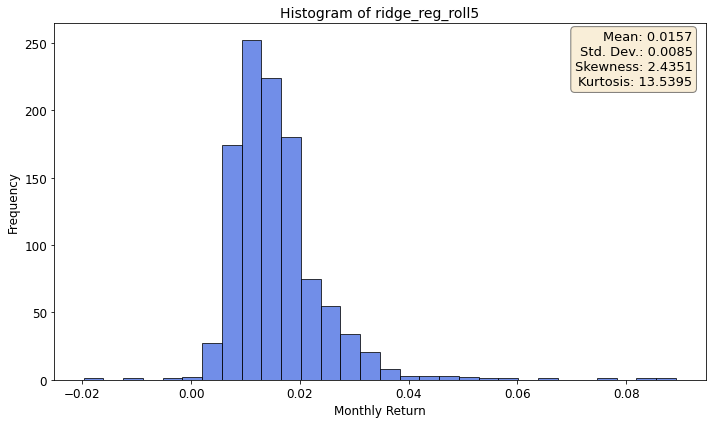

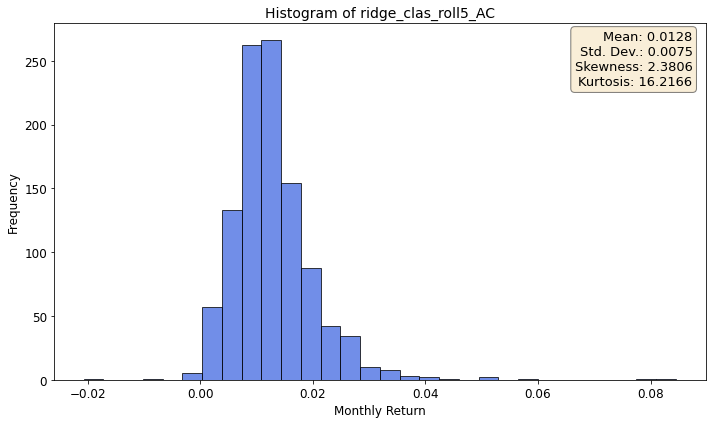

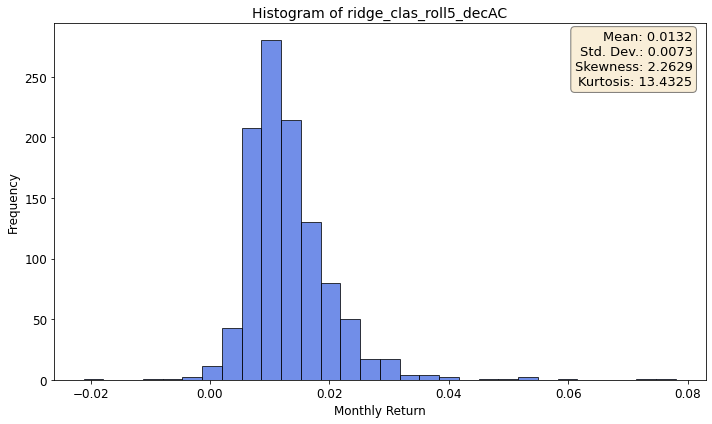

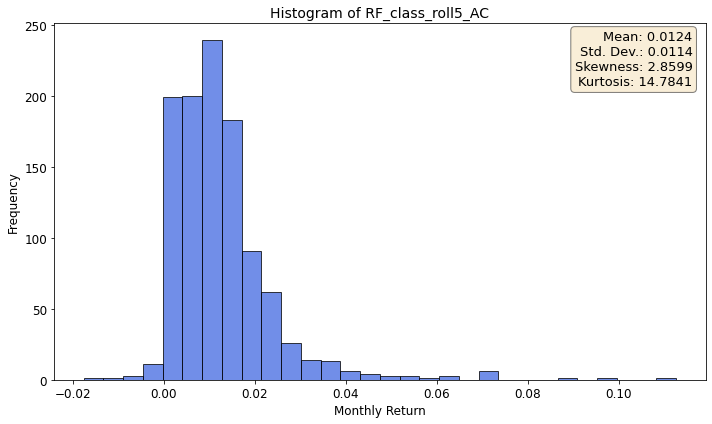

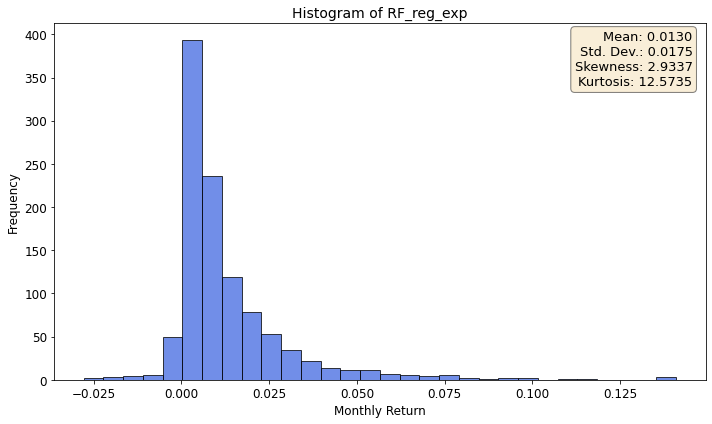

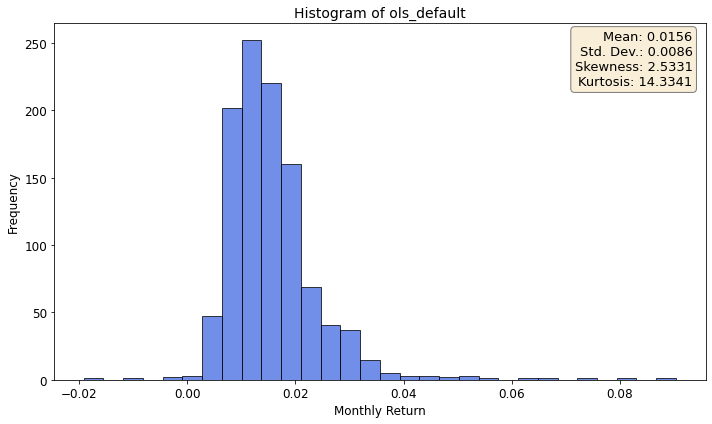

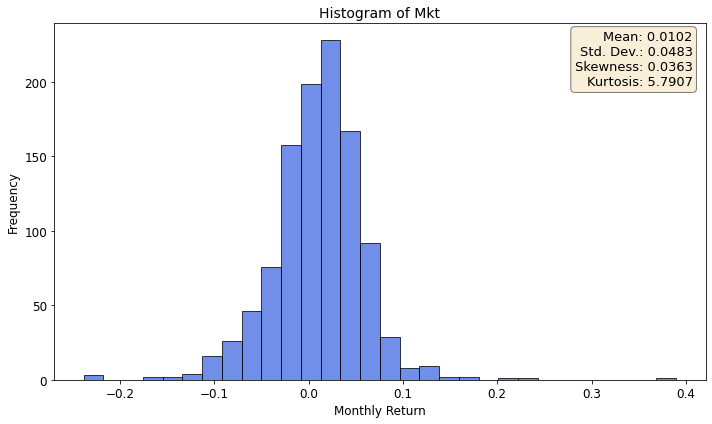

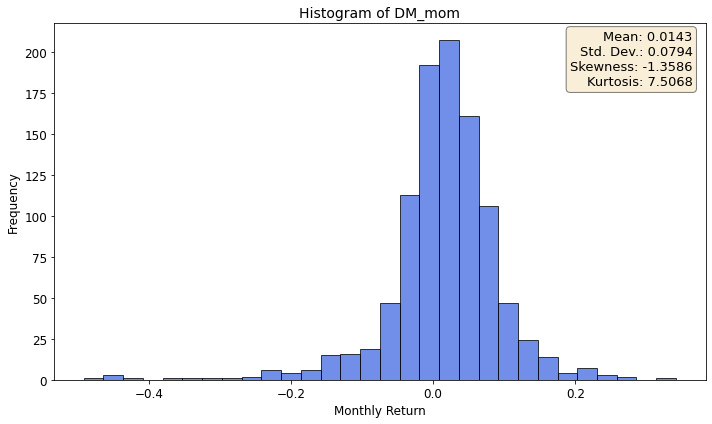

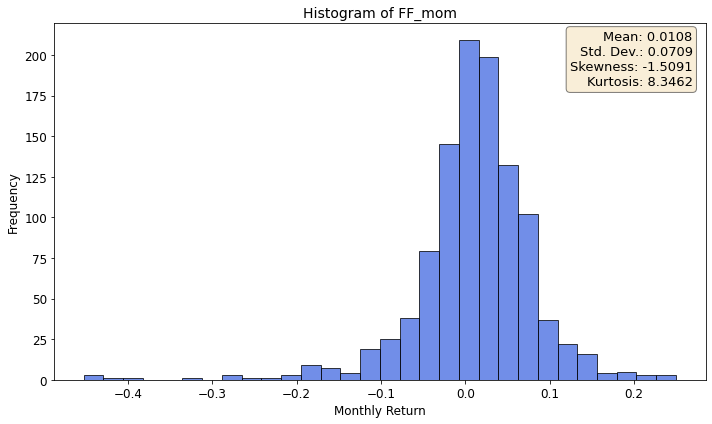

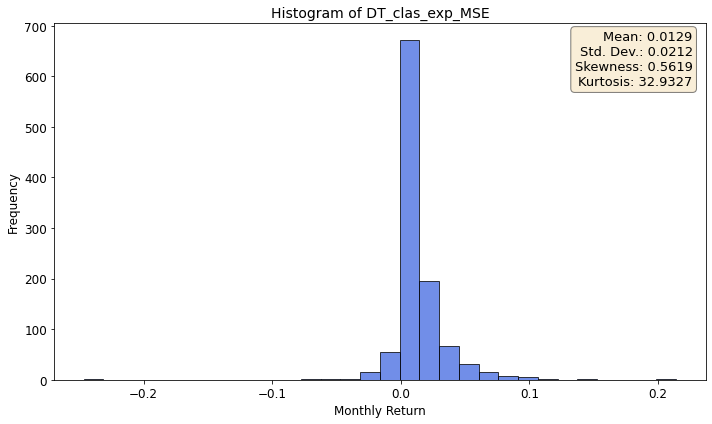

In [133]:
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import skew, kurtosis

# Assuming 'normal_ret' is your DataFrame and it's already loaded

def plot_histograms_separately(df, columns, bins=30, color='royalblue'):
    for column in columns:
        if column not in df.columns:
            print(f"Column '{column}' not found in DataFrame.")
            continue

        fig, ax = plt.subplots(figsize=(10, 6))
        values = df[column].dropna()  # Drop NaN values for accurate statistics
        mean_val = values.mean()
        std_dev_val = values.std()
        skewness_val = skew(values)
        kurtosis_val = kurtosis(values)

        ax.hist(values, bins=bins, alpha=0.75, color=color, edgecolor='black')
        ax.set_title(f'Histogram of {column}', fontsize=14)
        ax.set_xlabel('Monthly Return', fontsize=12)
        ax.set_ylabel('Frequency', fontsize=12)
        ax.xaxis.set_tick_params(labelsize=12)
        ax.yaxis.set_tick_params(labelsize=12)


        # Annotating the plot with statistical values
        stats_text = f'Mean: {mean_val:.4f}\nStd. Dev.: {std_dev_val:.4f}\nSkewness: {skewness_val:.4f}\nKurtosis: {kurtosis_val:.4f}'
        ax.text(0.98, 0.98, stats_text, transform=ax.transAxes, verticalalignment='top', horizontalalignment='right', fontsize=13, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

        plt.tight_layout()
        plt.show()



selected_columns = [ 'ridge_reg_roll5','ridge_clas_roll5_AC', 'ridge_clas_roll5_decAC', 'RF_class_roll5_AC', 'RF_reg_exp', 'ols_default',  'Mkt', 'DM_mom', 'FF_mom', 'DT_clas_exp_MSE']


plot_histograms_separately(normal_ret, selected_columns)


In [134]:
# for each column, calculate the average of the column and store in a new DataFrame

avg_ret = normal_ret.mean()

# rename the column to 'avg_ret' and index to 'model'
avg_ret = avg_ret.to_frame().reset_index()
avg_ret.columns = ['model', 'avg_ret']

# round the values in the 'avg_ret' column to 3 decimal places
avg_ret['avg_ret'] = avg_ret['avg_ret'].round(3)


avg_ret.head()

<ipython-input-134-fcce1330845f>:3: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  avg_ret = normal_ret.mean()


,model,avg_ret
0,ols_default_x,0.016
1,ridge_reg_exp,0.016
2,DT_reg_exp,0.013
3,ridge_reg_roll5,0.016
4,DT_reg_roll5,0.012


In [135]:
excess_ret = normal_ret.copy()

# Calculate excess return (i.e. subtract the RF column) for columns in 'models' list
for model in models:
    excess_ret[model] = excess_ret[model] - excess_ret['RF']

# Calculate excess return for the momentum strategies
excess_ret['DM_mom'] = excess_ret['DM_mom'] - excess_ret['RF']
excess_ret['FF_mom'] = excess_ret['FF_mom'] - excess_ret['RF']

excess_ret.head()


,date,ols_default_x,ridge_reg_exp,DT_reg_exp,ridge_reg_roll5,DT_reg_roll5,ridge_reg_roll10,DT_reg_roll10,ridge_reg_roll20,DT_reg_roll20,Mkt,RF_reg_roll5,RF_reg_roll10,RF_reg_exp,logit_default,ridge_clas_exp_AC,DT_clas_exp_AC,ridge_clas_roll5_AC,DT_class_roll5_AC,ridge_clas_roll10_AC,DT_class_roll10_AC,ridge_clas_roll20_AC,DT_class_roll20_AC,RF_class_roll5_AC,RF_class_roll20_AC,RF_class_roll10_AC,RF_clas_exp_AC_x,ols_default,ridge_clas_exp_MSE,DT_clas_exp_MSE,ridge_clas_roll5_MSE,DT_class_roll5_MSE,ridge_clas_roll10_MSE,DT_class_roll10_MSE,ridge_clas_roll20_MSE,DT_class_roll20_MSE,RF_class_roll5_MSE,RF_class_roll10_MSE,RF_class_roll20_MSE,RF_reg_roll20,ridge_reg_roll5_decAC,ridge_clas_roll5_decAC,Mkt-RF,SMB3,HML3,RF,SMB5,HML5,RMW5,CMA5,DM_mom,FF_mom
0,1933-01-31,0.020206,0.020206,0.005117,0.020232,0.006117,0.020232,0.006011,0.020232,0.006011,0.0125,0.006333,0.006115,0.006294,0.021457,0.021457,0.005194,0.021457,0.006117,0.021457,0.005046,0.021457,0.006011,0.005885,0.005607,0.005607,0.005976,0.020206,0.021457,0.005194,0.021457,0.006117,0.021457,0.005046,0.021457,0.005046,0.028710,0.005607,0.005607,0.006333,0.020930,0.021787,0.0125,0.0063,0.0636,0.0001,NaN,NaN,NaN,NaN,-0.01955,-0.0140
1,1933-02-28,0.011309,0.011309,0.092840,0.011309,0.065618,0.011309,0.092895,0.011309,0.092895,-0.1524,0.065618,0.065618,0.065618,0.009285,0.009301,0.092840,0.009285,0.065618,0.009301,0.095544,0.009301,0.092895,0.056112,0.065799,0.065799,0.065669,0.011309,0.009301,0.092840,0.009285,0.065618,0.009301,0.095544,0.009301,0.095544,0.044188,0.065799,0.065799,0.065618,0.011255,0.009216,-0.1524,-0.0258,-0.0295,-0.0003,NaN,NaN,NaN,NaN,0.09572,0.0852
2,1933-03-31,0.027639,0.027639,0.026035,0.027632,0.025840,0.027639,0.022826,0.027639,0.022826,0.0329,0.025824,0.026226,0.026340,0.028065,0.028065,0.026035,0.028065,0.025840,0.028065,0.022826,0.028065,0.022826,0.026143,0.026484,0.026484,0.040066,0.027639,0.028065,0.026035,0.028065,0.025840,0.028065,0.022826,0.028065,0.022826,0.039449,0.026484,0.026484,0.025824,0.027653,0.028087,0.0329,0.0379,0.0754,0.0004,NaN,NaN,NaN,NaN,0.12749,0.1492
3,1933-04-30,0.074182,0.074182,-0.019050,0.074182,-0.008120,0.074182,-0.012573,0.074182,-0.012573,0.3885,-0.006987,-0.004213,-0.007322,0.049330,0.049330,-0.010979,0.049056,-0.008120,0.049330,-0.019039,0.049330,-0.012573,-0.003829,-0.008553,-0.008553,-0.009506,0.074182,0.049330,-0.010979,0.049056,-0.008120,0.049330,-0.019039,0.049330,-0.019039,-0.003801,-0.008553,-0.008553,-0.006987,0.074213,0.049076,0.3885,0.0307,0.1965,0.0010,NaN,NaN,NaN,NaN,-0.44102,-0.4419
4,1933-05-31,0.023781,0.023811,-0.246918,0.023811,-0.246918,0.021886,-0.246918,0.021886,-0.246918,0.2143,-0.005305,-0.004173,-0.004423,0.019393,0.018923,-0.246918,0.019542,-0.246918,0.018923,-0.246918,0.018923,-0.246918,-0.004308,-0.004293,-0.004293,-0.004933,0.023781,0.018923,-0.246918,0.019483,-0.246918,0.018923,-0.246918,0.018923,-0.246918,-0.004308,-0.004293,-0.004293,-0.005305,0.023825,0.020253,0.2143,0.3656,0.1919,0.0004,NaN,NaN,NaN,NaN,-0.27389,-0.2707


In [136]:
# save the excess_ret DataFrame to a .dta file
excess_ret.to_csv('base_excess_ret.csv', index=False)

### Calculating Sharpe Ratios and Abnormal Returns


In [137]:
import statsmodels.api as sm

In [138]:
models = excess_ret.columns
models = models.drop(['date', 'Mkt', 'SMB3', 'HML3', 'RF', 'SMB5', 'HML5', 'RMW5', 'CMA5', 'Mkt-RF'])
models

Index(['ols_default_x', 'ridge_reg_exp', 'DT_reg_exp', 'ridge_reg_roll5',
       'DT_reg_roll5', 'ridge_reg_roll10', 'DT_reg_roll10', 'ridge_reg_roll20',
       'DT_reg_roll20', 'RF_reg_roll5', 'RF_reg_roll10', 'RF_reg_exp',
       'logit_default', 'ridge_clas_exp_AC', 'DT_clas_exp_AC',
       'ridge_clas_roll5_AC', 'DT_class_roll5_AC', 'ridge_clas_roll10_AC',
       'DT_class_roll10_AC', 'ridge_clas_roll20_AC', 'DT_class_roll20_AC',
       'RF_class_roll5_AC', 'RF_class_roll20_AC', 'RF_class_roll10_AC',
       'RF_clas_exp_AC_x', 'ols_default', 'ridge_clas_exp_MSE',
       'DT_clas_exp_MSE', 'ridge_clas_roll5_MSE', 'DT_class_roll5_MSE',
       'ridge_clas_roll10_MSE', 'DT_class_roll10_MSE', 'ridge_clas_roll20_MSE',
       'DT_class_roll20_MSE', 'RF_class_roll5_MSE', 'RF_class_roll10_MSE',
       'RF_class_roll20_MSE', 'RF_reg_roll20', 'ridge_reg_roll5_decAC',
       'ridge_clas_roll5_decAC', 'DM_mom', 'FF_mom'],
      dtype='object')

In [139]:
models = excess_ret.columns
models = models.drop(['date', 'Mkt', 'SMB3', 'HML3', 'RF', 'SMB5', 'HML5', 'RMW5', 'CMA5', 'Mkt-RF'])

# Initialize DataFrame to hold all results
backtest = pd.DataFrame(columns=['Model', 'Ann_Sharpe', 'CAPM_a', 'CAPM_p', 'FF3_a', 'FF3_p', 'FF5_a', 'FF5_p'])

# Prepare X variables for CAPM and Three-Factor models outside the loop
X_capm = sm.add_constant(excess_ret['Mkt-RF'])  # CAPM
X_ff3 = sm.add_constant(excess_ret[['Mkt-RF', 'SMB3', 'HML3']])  # Three-Factor

# Drop rows with NaN values in Five-Factor model variables
X_ff5_clean = excess_ret[['Mkt-RF', 'SMB5', 'HML5', 'RMW5', 'CMA5']].dropna()
X_ff5 = sm.add_constant(X_ff5_clean)  # Five-Factor

for model in models:
    # Assuming y might contain NaNs, drop them for alignment
    y = excess_ret[model].dropna()
    
    # Ensure alignment of y with each X variable
    # CAPM model fit
    aligned_X_capm = X_capm.loc[y.index]
    capm_results = sm.OLS(y, aligned_X_capm).fit()
    
    # Three-Factor model fit
    aligned_X_ff3 = X_ff3.loc[y.index]
    ff3_results = sm.OLS(y, aligned_X_ff3).fit()
    
    # Five-Factor model fit, ensuring alignment with the clean X_ff5 index
    aligned_X_ff5 = X_ff5.loc[X_ff5.index.intersection(y.index)]
    y_aligned_ff5 = y.loc[aligned_X_ff5.index]
    ff5_results = sm.OLS(y_aligned_ff5, aligned_X_ff5).fit()
    
    # Calculate and round the annualized Sharpe ratio
    mean_excess_return = y.mean()
    std_dev_excess_returns = y.std()
    ann_sharpe = round((mean_excess_return / std_dev_excess_returns) * np.sqrt(12), 2)  # Square root of 12 for monthly data
    
    # Round alpha and p-values
    capm_a = round(capm_results.params[0], 3)
    capm_p = round(capm_results.pvalues[0], 3)
    ff3_a = round(ff3_results.params[0], 3)
    ff3_p = round(ff3_results.pvalues[0], 3)
    ff5_a = round(ff5_results.params[0], 3)
    ff5_p = round(ff5_results.pvalues[0], 3)
    
    # Append results to the DataFrame
    backtest = backtest.append({
        'Model': model,
        'Ann_Sharpe': ann_sharpe/10,
        'CAPM_a': capm_a,
        'CAPM_p': capm_p,
        'FF3_a': ff3_a,
        'FF3_p': ff3_p,
        'FF5_a': ff5_a,
        'FF5_p': ff5_p,
    }, ignore_index=True)


# drop the row where the model is 'Mkt'
#backtest = backtest[backtest['Model'] != 'Mkt']

# Display the compiled results
backtest.head(10)


,Model,Ann_Sharpe,CAPM_a,CAPM_p,FF3_a,FF3_p,FF5_a,FF5_p
0,ols_default_x,0.537,0.012,0.0,0.012,0.0,0.013,0.0
1,ridge_reg_exp,0.537,0.012,0.0,0.012,0.0,0.013,0.0
2,DT_reg_exp,0.167,0.013,0.0,0.013,0.0,0.013,0.0
3,ridge_reg_roll5,0.542,0.012,0.0,0.012,0.0,0.013,0.0
4,DT_reg_roll5,0.127,0.012,0.0,0.012,0.0,0.012,0.0
5,ridge_reg_roll10,0.540,0.012,0.0,0.012,0.0,0.013,0.0
6,DT_reg_roll10,0.141,0.013,0.0,0.013,0.0,0.012,0.0
7,ridge_reg_roll20,0.538,0.012,0.0,0.012,0.0,0.013,0.0
8,DT_reg_roll20,0.166,0.013,0.0,0.013,0.0,0.013,0.0
9,RF_reg_roll5,0.185,0.012,0.0,0.012,0.0,0.012,0.0


In [140]:
backtest.sort_values('Ann_Sharpe', ascending=False, inplace=True)

In [141]:
# round the total_cum_logret column to 4 decimal places
final_log_ret_df['total_cum_logret'] = final_log_ret_df['total_cum_logret'].round(3)

# if the value in the column "model" of final_log_ret_df starts with "l_" then remove the "l_" from the value
final_log_ret_df['model'] = final_log_ret_df['model'].apply(lambda x: x[2:] if x.startswith('l_') else x)

# merge with avg_ret DataFrame on the 'model' column
backtest = backtest.merge(avg_ret, left_on='Model', right_on='model', how='left')

# remove the model column
backtest.drop('model', axis=1, inplace=True)

# drop row where Model is ols_default_x	
backtest = backtest[backtest['Model'] != 'ols_default_x']


backtest.head(50)



,Model,Ann_Sharpe,CAPM_a,CAPM_p,FF3_a,FF3_p,FF5_a,FF5_p,avg_ret
0,ridge_reg_roll5,0.542,0.012,0.0,0.012,0.0,0.013,0.0,0.016
1,ridge_reg_roll10,0.540,0.012,0.0,0.012,0.0,0.013,0.0,0.016
2,ridge_reg_roll20,0.538,0.012,0.0,0.012,0.0,0.013,0.0,0.016
4,ols_default,0.537,0.012,0.0,0.012,0.0,0.013,0.0,0.016
5,ridge_reg_exp,0.537,0.012,0.0,0.012,0.0,0.013,0.0,0.016
6,ridge_reg_roll5_decAC,0.529,0.012,0.0,0.012,0.0,0.012,0.0,0.015
7,ridge_clas_roll5_decAC,0.488,0.010,0.0,0.010,0.0,0.010,0.0,0.013
8,ridge_clas_roll5_AC,0.471,0.010,0.0,0.010,0.0,0.010,0.0,0.013
9,ridge_clas_roll10_AC,0.471,0.010,0.0,0.010,0.0,0.010,0.0,0.013
10,logit_default,0.452,0.010,0.0,0.010,0.0,0.010,0.0,0.013


In [142]:
# merge the final_log_ret_df and backtest DataFrames on the 'model' column
backtest = backtest.merge(final_log_ret_df, left_on='Model', right_on='model', how='left')

# remove the model column
backtest.drop('model', axis=1, inplace=True)

backtest.head(10)

,Model,Ann_Sharpe,CAPM_a,CAPM_p,FF3_a,FF3_p,FF5_a,FF5_p,avg_ret,total_cum_logret,Type,Method,Metric,Algorithm
0,ridge_reg_roll5,0.542,0.012,0.0,0.012,0.0,0.013,0.0,0.016,16.611,reg,roll5,mse,ridge
1,ridge_reg_roll10,0.540,0.012,0.0,0.012,0.0,0.013,0.0,0.016,16.610,reg,roll10,mse,ridge
2,ridge_reg_roll20,0.538,0.012,0.0,0.012,0.0,0.013,0.0,0.016,16.622,reg,roll20,mse,ridge
3,ols_default,0.537,0.012,0.0,0.012,0.0,0.013,0.0,0.016,16.607,reg,exp,mse,ols
4,ridge_reg_exp,0.537,0.012,0.0,0.012,0.0,0.013,0.0,0.016,16.608,reg,exp,mse,ridge
5,ridge_reg_roll5_decAC,0.529,0.012,0.0,0.012,0.0,0.012,0.0,0.015,16.034,reg,roll5,acc,ridge
6,ridge_clas_roll5_decAC,0.488,0.010,0.0,0.010,0.0,0.010,0.0,0.013,13.978,class,roll5,acc,ridge
7,ridge_clas_roll5_AC,0.471,0.010,0.0,0.010,0.0,0.010,0.0,0.013,13.626,class,roll5,acc,ridge
8,ridge_clas_roll10_AC,0.471,0.010,0.0,0.010,0.0,0.010,0.0,0.013,13.980,class,roll10,acc,ridge
9,logit_default,0.452,0.010,0.0,0.010,0.0,0.010,0.0,0.013,13.600,class,exp,mse,logit


In [143]:
# save the backtest into parquet
backtest.to_parquet('backtest.parquet')

In [144]:
# sort the backtest using Ann_sharpe in descending order
backtest.sort_values('Ann_Sharpe', ascending=False, inplace=True)
backtest.head(50)

,Model,Ann_Sharpe,CAPM_a,CAPM_p,FF3_a,FF3_p,FF5_a,FF5_p,avg_ret,total_cum_logret,Type,Method,Metric,Algorithm
0,ridge_reg_roll5,0.542,0.012,0.0,0.012,0.0,0.013,0.0,0.016,16.611,reg,roll5,mse,ridge
1,ridge_reg_roll10,0.540,0.012,0.0,0.012,0.0,0.013,0.0,0.016,16.610,reg,roll10,mse,ridge
2,ridge_reg_roll20,0.538,0.012,0.0,0.012,0.0,0.013,0.0,0.016,16.622,reg,roll20,mse,ridge
3,ols_default,0.537,0.012,0.0,0.012,0.0,0.013,0.0,0.016,16.607,reg,exp,mse,ols
4,ridge_reg_exp,0.537,0.012,0.0,0.012,0.0,0.013,0.0,0.016,16.608,reg,exp,mse,ridge
5,ridge_reg_roll5_decAC,0.529,0.012,0.0,0.012,0.0,0.012,0.0,0.015,16.034,reg,roll5,acc,ridge
6,ridge_clas_roll5_decAC,0.488,0.010,0.0,0.010,0.0,0.010,0.0,0.013,13.978,class,roll5,acc,ridge
7,ridge_clas_roll5_AC,0.471,0.010,0.0,0.010,0.0,0.010,0.0,0.013,13.626,class,roll5,acc,ridge
8,ridge_clas_roll10_AC,0.471,0.010,0.0,0.010,0.0,0.010,0.0,0.013,13.980,class,roll10,acc,ridge
9,logit_default,0.452,0.010,0.0,0.010,0.0,0.010,0.0,0.013,13.600,class,exp,mse,logit


In [145]:
# print the average annualized Sharpe ratio for each type and method
print(backtest.groupby(['Type', 'Method'])['Ann_Sharpe'].mean())

Type   Method
class  exp       0.304500
       roll10    0.266167
       roll20    0.258500
       roll5     0.300571
reg    exp       0.361500
       roll10    0.289333
       roll20    0.297333
       roll5     0.345750
Name: Ann_Sharpe, dtype: float64


In [146]:
# Convert categorical variables into dummy variables
backtest_dummies = pd.get_dummies(backtest, columns=['Type', 'Method', 'Metric', 'Algorithm'])

# Define the base formula components excluding CAPM, FF3, and FF5 related columns
base_formula_components = ['Type', 'Method', 'Metric', 'Algorithm']

# Construct the formula for Sharpe Ratio regression
formula_sharpe = 'Ann_Sharpe ~ ' + ' + '.join([f'C({component})' for component in base_formula_components])

# Construct the formula for Total Cumulative Logarithmic Return regression
formula_logret = 'total_cum_logret ~ ' + ' + '.join([f'C({component})' for component in base_formula_components])

# Perform the regression for Sharpe Ratio
model_sharpe = smf.ols(formula=formula_sharpe, data=backtest).fit()

# Perform the regression for Total Cumulative Logarithmic Return
model_logret = smf.ols(formula=formula_logret, data=backtest).fit()

# Print the summary tables for both regressions
print("Regression for Sharpe Ratio:\n", model_sharpe.summary())
print("\nRegression for Total Cumulative Logarithmic Return:\n", model_logret.summary())


Regression for Sharpe Ratio:
                             OLS Regression Results                            
Dep. Variable:             Ann_Sharpe   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     37.31
Date:                Wed, 06 Mar 2024   Prob (F-statistic):           1.42e-13
Time:                        16:23:08   Log-Likelihood:                 67.958
No. Observations:                  39   AIC:                            -115.9
Df Residuals:                      29   BIC:                            -99.28
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------


In [147]:
backtest = backtest.merge(metrics_df[['Accuracy', 'MAE', 'MSE']], left_on='Model', right_index=True, how='left')
backtest.rename(columns={'Accuracy': 'Acc_tot', 'MAE': 'MAE_tot', 'MSE': 'MSE_tot'}, inplace=True)
backtest = backtest.merge(metrics_decile[['Accuracy', 'MAE', 'MSE']], left_on='Model', right_index=True, how='left')
backtest.rename(columns={'Accuracy': 'Acc_dec', 'MAE': 'MAE_dec', 'MSE': 'MSE_dec'}, inplace=True)
backtest.head(50)

,Model,Ann_Sharpe,CAPM_a,CAPM_p,FF3_a,FF3_p,FF5_a,FF5_p,avg_ret,total_cum_logret,Type,Method,Metric,Algorithm,Acc_tot,MAE_tot,MSE_tot,Acc_dec,MAE_dec,MSE_dec
0,ridge_reg_roll5,0.542,0.012,0.0,0.012,0.0,0.013,0.0,0.016,16.611,reg,roll5,mse,ridge,0.822525,0.352350,0.153341,0.978340,0.217517,0.091180
1,ridge_reg_roll10,0.540,0.012,0.0,0.012,0.0,0.013,0.0,0.016,16.610,reg,roll10,mse,ridge,0.823577,0.352028,0.152658,0.977841,0.213606,0.086968
2,ridge_reg_roll20,0.538,0.012,0.0,0.012,0.0,0.013,0.0,0.016,16.622,reg,roll20,mse,ridge,0.822878,0.352083,0.152689,0.977582,0.213794,0.087061
3,ols_default,0.537,0.012,0.0,0.012,0.0,0.013,0.0,0.016,16.607,reg,exp,mse,ols,0.823020,0.352016,0.152656,0.977404,0.214626,0.087825
4,ridge_reg_exp,0.537,0.012,0.0,0.012,0.0,0.013,0.0,0.016,16.608,reg,exp,mse,ridge,0.823176,0.352029,0.152646,0.977609,0.214610,0.087752
5,ridge_reg_roll5_decAC,0.529,0.012,0.0,0.012,0.0,0.012,0.0,0.015,16.034,reg,roll5,acc,ridge,0.823052,0.350800,0.152277,0.977853,0.217475,0.091372
6,ridge_clas_roll5_decAC,0.488,0.010,0.0,0.010,0.0,0.010,0.0,0.013,13.978,class,roll5,acc,ridge,0.835803,0.208363,0.102729,0.985377,0.017395,0.009546
7,ridge_clas_roll5_AC,0.471,0.010,0.0,0.010,0.0,0.010,0.0,0.013,13.626,class,roll5,acc,ridge,0.832911,0.209604,0.104508,0.984683,0.017187,0.009949
8,ridge_clas_roll10_AC,0.471,0.010,0.0,0.010,0.0,0.010,0.0,0.013,13.980,class,roll10,acc,ridge,0.834708,0.209025,0.104216,0.985191,0.016907,0.009758
9,logit_default,0.452,0.010,0.0,0.010,0.0,0.010,0.0,0.013,13.600,class,exp,mse,logit,0.834334,0.207177,0.104523,0.984598,0.016562,0.009981


In [136]:
# OLS: Ann_Sharpe ~ Acc_tot
model_acc_tot = smf.ols(formula='Ann_Sharpe ~ Acc_tot', data=backtest).fit()

# OLS: Ann_Sharpe ~ Acc_dec
model_acc_dec = smf.ols(formula='Ann_Sharpe ~ Acc_dec', data=backtest).fit()

# OLS: Ann_Sharpe ~ MSE_tot
model_mse_tot = smf.ols(formula='Ann_Sharpe ~ MSE_tot', data=backtest).fit()

# OLS: Ann_Sharpe ~ MSE_dec
model_mse_dec = smf.ols(formula='Ann_Sharpe ~ MSE_dec', data=backtest).fit()

# print the summary tables for both regressions
print("Regression for Ann_Sharpe ~ Acc_tot:\n", model_acc_tot.summary())
print("\nRegression for Ann_Sharpe ~ Acc_dec:\n", model_acc_dec.summary())
print("\nRegression for Ann_Sharpe ~ MSE_tot:\n", model_mse_tot.summary())
print("\nRegression for Ann_Sharpe ~ MSE_dec:\n", model_mse_dec.summary())



Regression for Ann_Sharpe ~ Acc_tot:
                             OLS Regression Results                            
Dep. Variable:             Ann_Sharpe   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                 -0.014
Method:                 Least Squares   F-statistic:                    0.4997
Date:                Sat, 02 Mar 2024   Prob (F-statistic):              0.484
Time:                        11:11:15   Log-Likelihood:                 17.879
No. Observations:                  38   AIC:                            -31.76
Df Residuals:                      36   BIC:                            -28.48
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     

In [137]:
# OLS: total_cum_logret ~ Acc_tot
model_logret_acc_tot = smf.ols(formula='total_cum_logret ~ Acc_tot', data=backtest).fit()

# OLS: total_cum_logret ~ Acc_dec
model_logret_acc_dec = smf.ols(formula='total_cum_logret ~ Acc_dec', data=backtest).fit()

# OLS: total_cum_logret ~ MSE_tot
model_logret_mse_tot = smf.ols(formula='total_cum_logret ~ MSE_tot', data=backtest).fit()

# OLS: total_cum_logret ~ MSE_dec
model_logret_mse_dec = smf.ols(formula='total_cum_logret ~ MSE_dec', data=backtest).fit()

# print the summary tables for both regressions
print("Regression for total_cum_logret ~ Acc_tot:\n", model_logret_acc_tot.summary())
print("\nRegression for total_cum_logret ~ Acc_dec:\n", model_logret_acc_dec.summary())
print("\nRegression for total_cum_logret ~ MSE_tot:\n", model_logret_mse_tot.summary())
print("\nRegression for total_cum_logret ~ MSE_dec:\n", model_logret_mse_dec.summary())


Regression for total_cum_logret ~ Acc_tot:
                             OLS Regression Results                            
Dep. Variable:       total_cum_logret   R-squared:                       0.353
Model:                            OLS   Adj. R-squared:                  0.335
Method:                 Least Squares   F-statistic:                     19.67
Date:                Sat, 02 Mar 2024   Prob (F-statistic):           8.33e-05
Time:                        11:11:15   Log-Likelihood:                -62.560
No. Observations:                  38   AIC:                             129.1
Df Residuals:                      36   BIC:                             132.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercep